# Анализ и прогноз удовлетворённости и оттока сотрудников для компании «Работа с заботой»

### Описание проекта:
Цели проекта заключаются в создании эффективных моделей для прогнозирования уровня удовлетворённости сотрудников и вероятности их увольнения. Эти модели помогут HR-аналитикам компании «Работа с заботой» предоставлять бизнесу рекомендации по предотвращению финансовых потерь и уменьшению оттока сотрудников. Основываясь на данных о характеристиках сотрудников, в том числе на уровне удовлетворённости, модели будут быстрее и точнее отвечать на важные для компании вопросы. 

Удовлетворённость сотрудников критически важна для сокращения оттока, а своевременное прогнозирование увольнений позволит избежать внезапных кадровых потерь, особенно среди ключевых работников.

### Задачи проекта:
1. Построение модели для прогнозирования уровня удовлетворённости сотрудников на основе предоставленных данных.
2. Разработка модели для предсказания вероятности увольнения сотрудников.
3. Анализ значимых факторов, влияющих на удовлетворённость и отток, для предоставления бизнесу ценных инсайтов.
4. Улучшение процесса сбора данных об удовлетворённости сотрудников, чтобы сделать этот процесс более эффективным в большой компании.
5. Предложение рекомендаций для управления удовлетворённостью сотрудников и снижения риска оттока на основе результатов моделирования.

## Задача 1: предсказание удовлетворенности сотрудников

Информация о данных:

- `id` — уникальный идентификатор сотрудника;
- `dept` — отдел, в котором работает сотрудник;
- `level` — уровень занимаемой должности;
- `workload` — уровень загруженности сотрудника;
- `employment_years` — длительность работы в компании (в годах);
- `last_year_promo` — показывает, было ли повышение за последний год;
- `last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;
- `supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;
- `salary` — ежемесячная зарплата сотрудника;
- `job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании, целевой признак.

In [1]:
import sys
!pip install phik -q
!pip install shap -q

In [2]:
!pip install --upgrade scikit-learn==1.2.2 -q
!pip install --upgrade numpy==1.26.4 -q
!pip install --upgrade seaborn==0.13.0 -q
!pip install --upgrade shap==0.45.0 -q
!pip install --upgrade phik==0.12.4 -q
!pip install --upgrade pandas==2.1.4 -q
!pip install --upgrade scipy==1.12.0 -q
!pip install --upgrade matplotlib==3.8.0 -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.9.1 requires numpy<1.25.0,>=1.18.5, but you have numpy 1.26.4 which is incompatible.
numba 0.56.0 requires numpy<1.23,>=1.18, but you have numpy 1.26.4 which is incompatible.


### Импорты

In [3]:
from itertools import combinations
from math import log
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import phik
import numpy as np
import os
import shap
from scipy.stats import ttest_ind
shap.initjs()

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, Lasso, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_text
from sklearn.metrics import roc_auc_score, make_scorer

In [4]:
sns.set_theme()
sns.set_palette('Set2')
RANDOM_STATE = 5

### Шаг 1. Загрузка данных

Файлы с данными:
- Тренировочная выборка: `train_job_satisfaction_rate.csv`
- Входные признаки тестовой выборки: `test_features.csv`
- Целевой признак тестовой выборки: `test_target_satisfaction_rate.csv`

Используем функцию, чтобы рассмотреть какие данные представлены для обработки

Для возможности загрузить данные с локального хранилища и с платформы, будем использовать обработку ошибок не найденного файла.

In [5]:
def get_info(data: pd.DataFrame) -> None:
    '''
    Function for printing base information of dataframe
    :param data: dataframe for search
    '''
    print('Info about data:')
    data.info()
    print('\nInfo about missing data:\n', data.isna().sum())
    print('\nInfo about duplicates:\n', data.duplicated().sum())

In [6]:
if (os.path.exists('/datasets/train_job_satisfaction_rate.csv') and 
    os.path.exists('/datasets/test_features.csv') and 
    os.path.exists('/datasets/test_target_job_satisfaction_rate.csv')):
    tr_satisfaction = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
    ts_features = pd.read_csv('/datasets/test_features.csv')
    ts_target = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')
    print('Success, files was read') 
    
elif (os.path.exists('./datasets/train_job_satisfaction_rate.csv') and 
      os.path.exists('./datasets/test_features.csv') and
      os.path.exists('./datasets/test_target_job_satisfaction_rate.csv')):
    tr_satisfaction = pd.read_csv('./datasets/train_job_satisfaction_rate.csv')
    ts_features = pd.read_csv('./datasets/test_features.csv')
    ts_target = pd.read_csv('./datasets/test_target_job_satisfaction_rate.csv')
    print('Success, local files was read') 
    
else:
    print('something went wrong')

Success, files was read


<u>**Датасет для тренировочной выборки, содержащий характеристики сотрудников**</u>

In [7]:
tr_satisfaction.head()

id        dept   level workload  employment_years last_year_promo  \
0  155278       sales  junior   medium                 2              no   
1  653870          hr  junior     high                 2              no   
2  184592       sales  junior      low                 1              no   
3  171431  technology  junior      low                 4              no   
4  693419          hr  junior   medium                 1              no   

  last_year_violations  supervisor_evaluation  salary  job_satisfaction_rate  
0                   no                      1   24000                   0.58  
1                   no                      5   38400                   0.76  
2                   no                      2   12000                   0.11  
3                   no                      2   18000                   0.37  
4                   no                      3   22800                   0.20

In [8]:
get_info(tr_satisfaction)

Info about data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB

Info about missing data:
 id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0

Попробуем найти неявные дубликаты в виде повторяющегося `id`, уровня занимаемой должности и отдела, в котором работает сотрудник

In [9]:
tr_satisfaction.loc[tr_satisfaction.duplicated(subset=['id', 'level', 'dept'])]

Empty DataFrame
Columns: [id, dept, level, workload, employment_years, last_year_promo, last_year_violations, supervisor_evaluation, salary, job_satisfaction_rate]
Index: []

Для тренировочной выборки не было обнаружено каких-то неявных или полных дубликатов. Однако были обнаружены пропуски для данных `dept`, `level`

<u>**Рассмотрение датасетов для тестовой выборки, данные о таргете и входных признаках**</u>

In [10]:
ts_features.head()

id       dept   level workload  employment_years last_year_promo  \
0  485046  marketing  junior   medium                 2              no   
1  686555         hr  junior   medium                 1              no   
2  467458      sales  middle      low                 5              no   
3  418655      sales  middle      low                 6              no   
4  789145         hr  middle   medium                 5              no   

  last_year_violations  supervisor_evaluation  salary  
0                   no                      5   28800  
1                   no                      4   30000  
2                   no                      4   19200  
3                   no                      4   19200  
4                   no                      5   40800

In [11]:
get_info(ts_features)

Info about data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB

Info about missing data:
 id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary               

In [12]:
ts_features.loc[ts_features.duplicated(subset=['id', 'level', 'dept'])]

Empty DataFrame
Columns: [id, dept, level, workload, employment_years, last_year_promo, last_year_violations, supervisor_evaluation, salary]
Index: []

Неявных дубликатов и полных дубликатов среди данных тестовой выборки данных не было обнаружено. Однако были найдены пропуски в столбцах `dept`, `level`

In [13]:
ts_target.head()

id  job_satisfaction_rate
0  130604                   0.74
1  825977                   0.75
2  418490                   0.60
3  555320                   0.72
4  826430                   0.08

In [14]:
get_info(ts_target)

Info about data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB

Info about missing data:
 id                       0
job_satisfaction_rate    0
dtype: int64

Info about duplicates:
 0


**Вывод:**
- Для всех датасетов были произведены загрузки данных, просмотр представленных значений, оценка пропусков и дубликатов. По итогам данного знакомства с данными были обнаружены пропуски в тестовых и тренировочных данных для значений `dept`, `level`
- В тренировочной выборке представлено 4000 значений, в тестовой - 2000. Этих данных будет достаточно для проведения адекватной оценки работоспособности модели

### Шаг 2. Предобработка данных

Изучим данные и сделаем выводы. При необходимости произведем предобработку для некорректных значений.

In [15]:
def get_unique_values_with_counts(data: pd.DataFrame, col: pd.Series) -> str:
    """
    get values and their names into one str line
    params: data: dataframe for research
            col: column from dataframe for research
    return: str line with names and values
    """
    unique_values = data[col].unique()
    value_counts = data[col].value_counts()
    result = [f'{value} ({count})' for value, count in zip(unique_values, value_counts)]
    return ', '.join(result)


def unique_data(data: pd.DataFrame) -> None:
    """
    Output of unique data if it's count less tan ten
    params: data: dataframe for research
    """
    for col in data:
        if len(data[col].unique()) < 20:
            print(f'{col}: {get_unique_values_with_counts(data, col)}')

<u>**Датасет для тренировочной выборки, содержащий характеристики сотрудников**</u>

In [16]:
unique_data(tr_satisfaction)

dept: sales (1512), hr (866), technology (610), purchasing (550), marketing (456)
level: junior (1894), middle (1744), sinior (358)
workload: medium (2066), high (1200), low (734)
employment_years: 2 (966), 1 (785), 4 (483), 7 (384), 9 (380), 6 (301), 3 (287), 10 (193), 8 (130), 5 (91)
last_year_promo: no (3880), yes (120)
last_year_violations: no (3441), yes (559)
supervisor_evaluation: 1 (1603), 5 (1263), 2 (546), 3 (387), 4 (201)


In [17]:
tr_satisfaction['level'] = tr_satisfaction['level'].replace(['sinior', 'senior'], 'senior')

<u>**Рассмотрение датасетов для тестовой выборки, данные о таргете и входных признаках**</u>

In [18]:
unique_data(ts_features)

dept: marketing (763), hr (455), sales (279), purchasing (273), technology (227), nan (1)
level: junior (974), middle (854), sinior (171)
workload: medium (1043), low (593), high (363),   (1)
employment_years: 2 (522), 1 (374), 5 (234), 6 (187), 3 (179), 9 (174), 7 (138), 4 (91), 8 (66), 10 (35)
last_year_promo: no (1937), yes (63)
last_year_violations: no (1738), yes (262)
supervisor_evaluation: 5 (857), 4 (575), 3 (284), 1 (196), 2 (88)


In [19]:
ts_features['level'] = ts_features['level'].replace(['sinior', 'senior'], 'senior')

**Вывод:**
В данных присутствуют категориальные признаки, на месте которых есть не только пропуски, но и пропуски в виде "пробелов"

### Шаг 3. Исследовательский анализ данных

Изучим данные - рассмотрим распределение среди количественных и категориальных признаков, для этого используем как визуальные, так и описательные способы.

Для начала рассмотрим частоту встречаемости для дискретных и номинальных признаков.

In [20]:
def categorial_plot(df: pd.DataFrame, title: str, features: dict) -> None:
    '''
    Function for plotting categorial distribution
    params: df: dataframe for research
            tltle: name for plot title
            features: dict of features to research, keys - eng, values - ru for captions
    '''
    print(f'Графики категориальных признаков для {title}')

    for feature, feat_ru in features.items():
        data = df[feature].value_counts().to_frame().reset_index()
        if len(data['count'].unique()) > 1:
            fig, axes = plt.subplots(1, 2, figsize=(20, 4))
            fig.suptitle(f'Распределение для {feat_ru}')
            axes[0].yaxis.grid(True)
            sns.barplot(data=data, y=feature, x='count', ax=axes[0])
            axes[0].set_xlabel('Количество', fontsize=12)
            axes[0].set_ylabel(feat_ru, fontsize=12)
            axes[1].pie(data['count'], labels=data[feature], autopct='%.1f%%', radius=1)
        else:
            print(f'Для категориального признака "{feat_ru}" одинаковое количество данных на все группы: {data["count"][0]}')

In [21]:
def numerical_plot(df: pd.DataFrame, title: str, features: dict):
    '''
    function for plotting numerical distribution
    params: df: dataframe for research
            tltle: name for plot title
            features: dict of features to research, keys - eng, values - ru for captions
    '''
    print(f'Графики количественных признаков для {title}')
    for feature, feat_ru in features.items():
        fig, axes = plt.subplots(1, 2, figsize=(18, 5))
        if df[feature].dtype == 'int64' and len(df[feature].unique()) < 20:
            sns.countplot(data=df, x=feature, ax=axes[0])
        else:
            sns.histplot(data=df, x=feature, kde=True, ax=axes[0], bins=round(log((len(df[feature].unique()) + 1))*2, ))
        sns.boxplot(data=df, x=feature, ax=axes[1])
        fig.suptitle(f'Распределение для {feat_ru}')
        for num in range(2):
            axes[num].set_ylabel('Количество')
            axes[num].set_xlabel(feat_ru)

<u>**Датасет для тренировочной выборки, содержащий характеристики сотрудников**</u>

Создадим словарь для категориальных и количественных признаков, который мы будем использовать в дальнейшем при построении графиков и прочих методов анализа

In [22]:
categorial_features = {'dept': 'отдел_работы',
                      'level': 'занимаемая_должность',
                      'workload': 'загруженность',
                      'last_year_promo': 'повышение_последний_год',
                      'last_year_violations': 'нарушение_тд'}

In [23]:
numerical_features = {'employment_years': 'длительность_работы',
                     'salary': 'зарплата',
                     'supervisor_evaluation': 'оценка_работы'}

Выведем медиану, отклонения среднего, среднее и квартили для количественных характеристик датафрейма

In [24]:
tr_satisfaction[numerical_features.keys()].describe()

employment_years        salary  supervisor_evaluation
count       4000.000000   4000.000000            4000.000000
mean           3.718500  33926.700000               3.476500
std            2.542513  14900.703838               1.008812
min            1.000000  12000.000000               1.000000
25%            2.000000  22800.000000               3.000000
50%            3.000000  30000.000000               4.000000
75%            6.000000  43200.000000               4.000000
max           10.000000  98400.000000               5.000000

На основе этого можно сделать вывод о том, что среди сотрудников встречются люди с опытом от года до 10 лет, однако наиболее часто можно встретить сотрудника 1-3, чем старшего возраста - первый квартиль это сотрудники до трех лет

Средняя зарплата 34 тысячи, тогда как медианное значение 30 тысяч. Разброс зарплат составляет от 12 тысяч до 98,4 тысяч

Средняя оценка сотрудника 4, при максимальном значении 5. Это говорит о том, что большая часть сотрудников оценивается от трех баллов и выше

Графики количественных признаков для Распределение количественных характеристик датафрейма


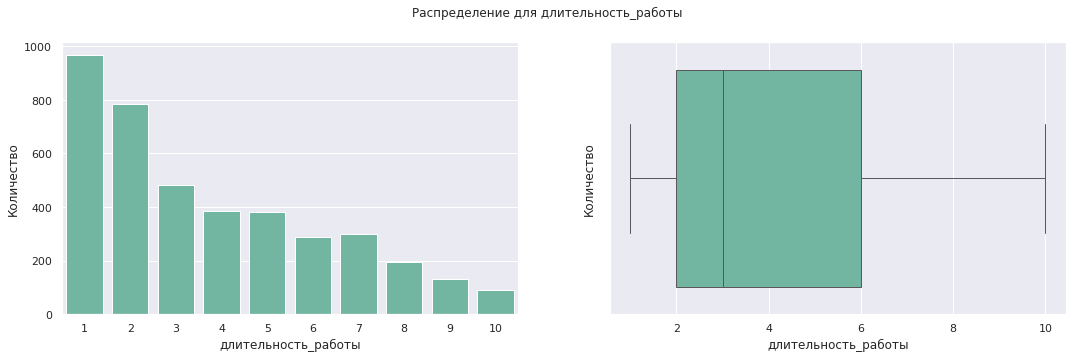

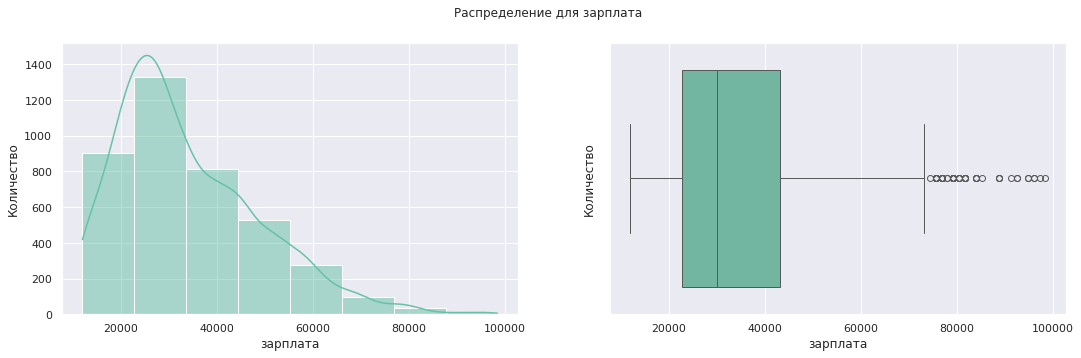

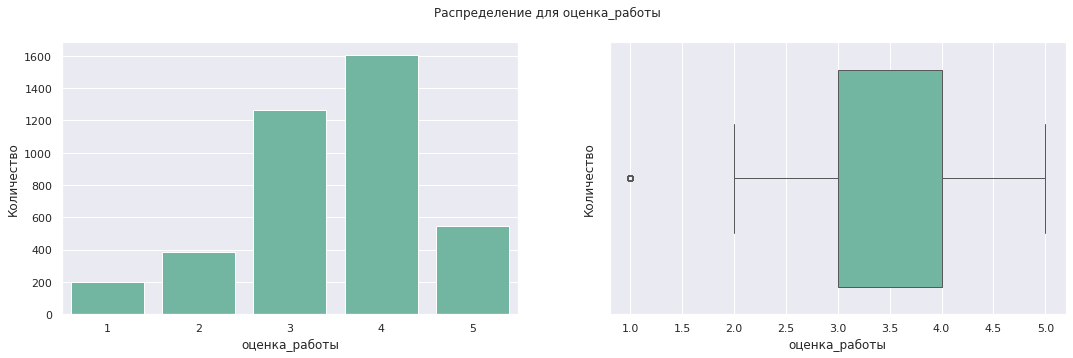

In [25]:
numerical_plot(tr_satisfaction, 'Распределение количественных характеристик датафрейма', numerical_features)

Среди распределений количественных данных нет нормального распределения.
- Для длительности работы мода - 1 год работы и далее количество сотрудников уменьшается с количеством года
- Наиболее часто ставят оценку 4, потом 3 и далее 5, 2 и 1 по убыванию. Однако количество проставления единиц мало по сравнению с другими оценками - в тренировочных данных 200 единиц на 4000 данных.
- Зарплаты выше 80 тыс рублей считаются статистическими выбросами, однако это вполне могут быть зарплатами руководителей

In [26]:
tr_satisfaction.query('salary > 80000').drop(columns='id').pivot_table(columns=['level', 'workload'], index='dept', values='salary')

level        senior
workload       high
dept               
hr          81360.0
marketing   82500.0
purchasing  80400.0
technology  91520.0

Действительно, от 80 тысяч - руководящие позиции

In [27]:
tr_satisfaction[categorial_features.keys()].describe()

dept   level workload last_year_promo last_year_violations
count    3994    3996     4000            4000                 4000
unique      5       3        3               2                    2
top     sales  junior   medium              no                   no
freq     1512    1894     2066            3880                 3441

Графики категориальных признаков для Распределение категориальных признаков


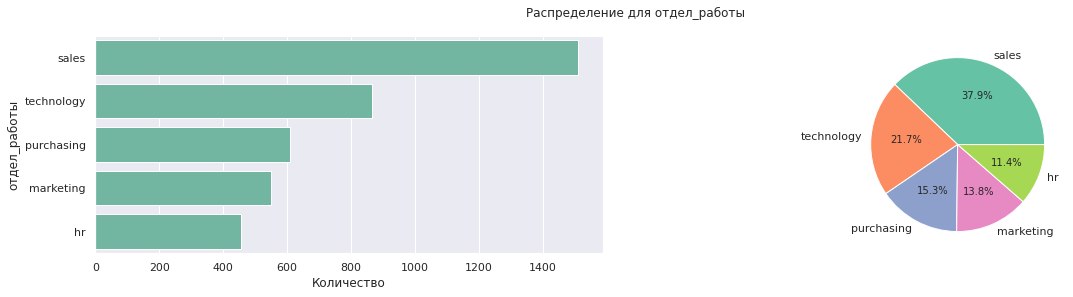

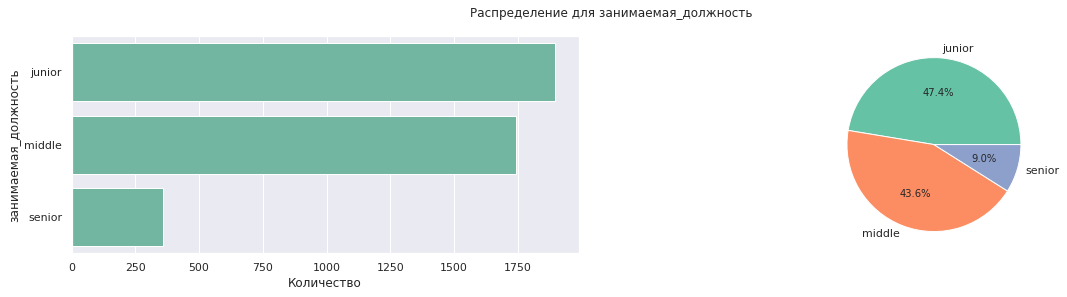

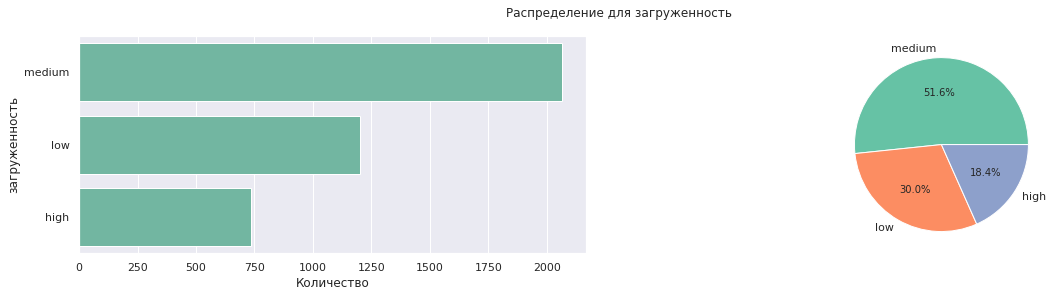

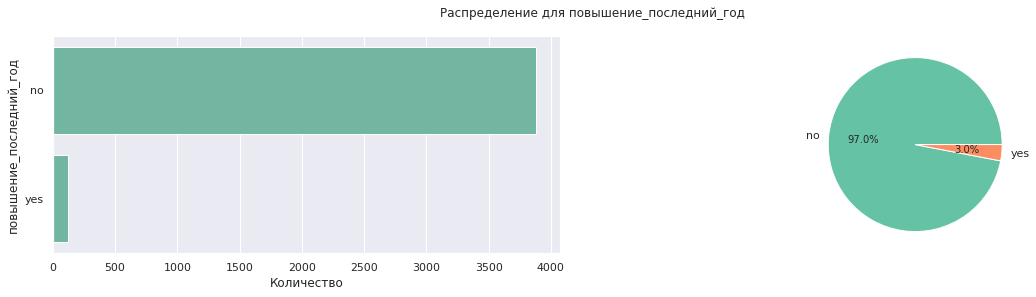

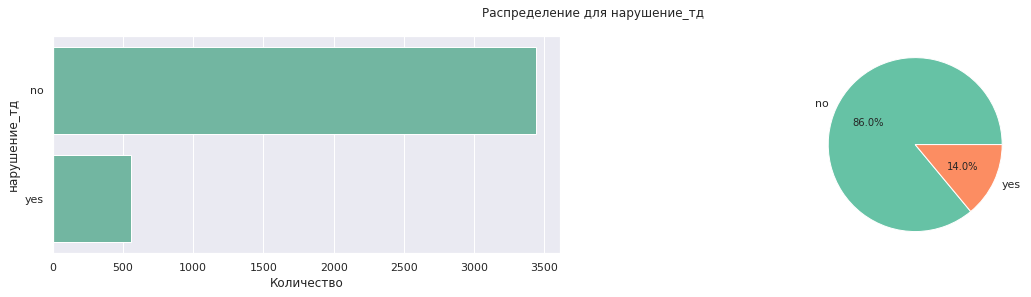

In [28]:
categorial_plot(tr_satisfaction, 'Распределение категориальных признаков', categorial_features)

На основе построенных графиков и статистических значений, самый популярный отдел - sales, в тренировочной выборке в нем работает 1512 сотрудников

Большую часть сотрудников составляют джуны и мидлы - их 47,4% и 43,6% соответственно

Для большинства сотрудников загруженность на работе на среднем уровне - это 51,6%, далее сотрудники оценили нагрузку как низкую - 30% и высокой она оказалась для 18,4% - примерно 750 человек

За последний год повышение получили только 3% сотрудников

14% или 559 человек из тренировочной нарушили трудовой договор за последний год

<u>**Рассмотрение датасетов для тестовой выборки, данные о таргете и входных признаках**</u>

In [29]:
ts_features[numerical_features.keys()].describe()

employment_years        salary  supervisor_evaluation
count       2000.000000   2000.000000            2000.000000
mean           3.666500  34066.800000               3.526500
std            2.537222  15398.436729               0.996892
min            1.000000  12000.000000               1.000000
25%            1.000000  22800.000000               3.000000
50%            3.000000  30000.000000               4.000000
75%            6.000000  43200.000000               4.000000
max           10.000000  96000.000000               5.000000

Графики количественных признаков для Распределение количественных переменных на тестовой выборке


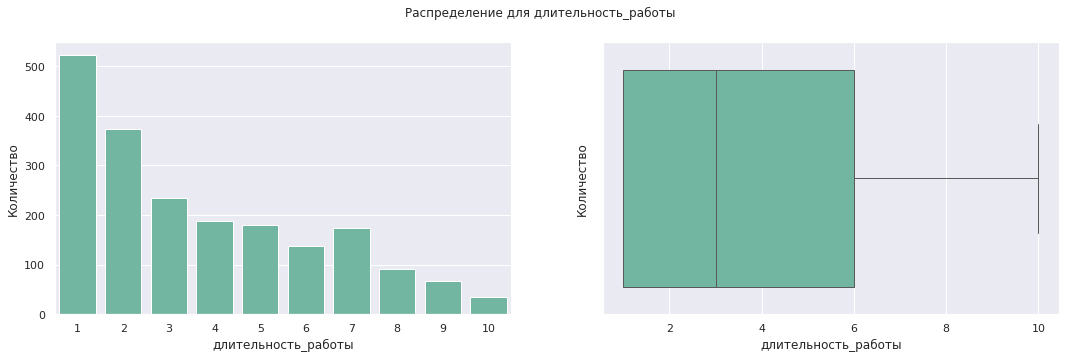

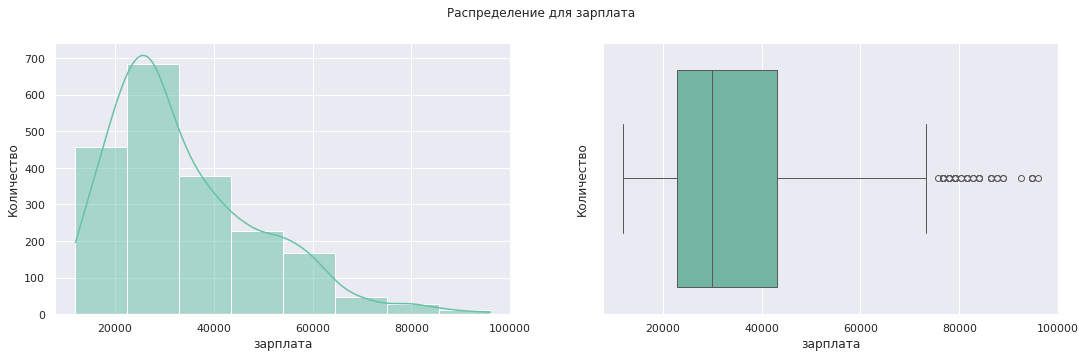

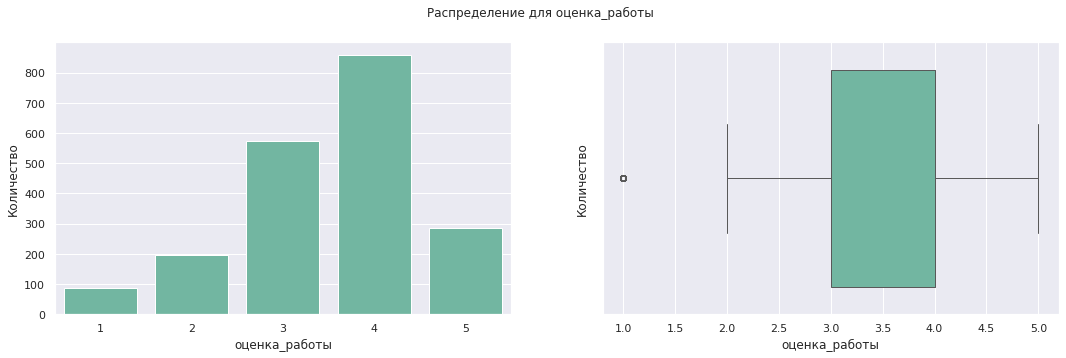

In [30]:
numerical_plot(ts_features, "Распределение количественных переменных на тестовой выборке", numerical_features)

Для тестовых данных можно заметить те же зависимости, что были описаны выше для тренировочной выборки

In [31]:
ts_features[categorial_features.keys()].describe()

dept   level workload last_year_promo last_year_violations
count    1998    1999     2000            2000                 2000
unique      6       3        4               2                    2
top     sales  junior   medium              no                   no
freq      763     974     1043            1937                 1738

Графики категориальных признаков для Распределение категориальных признаков на тестовой выборке


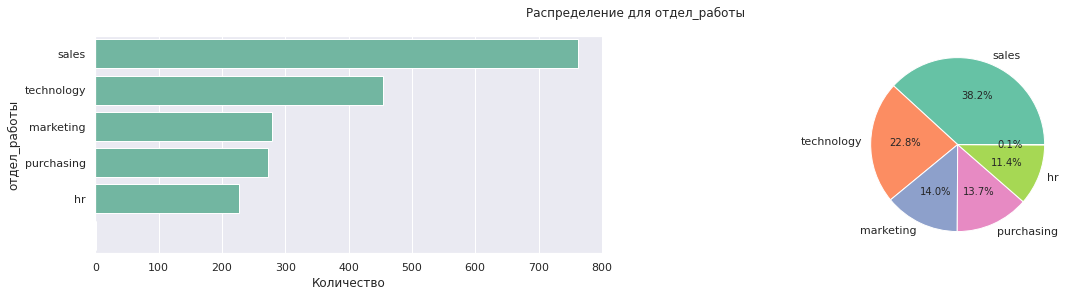

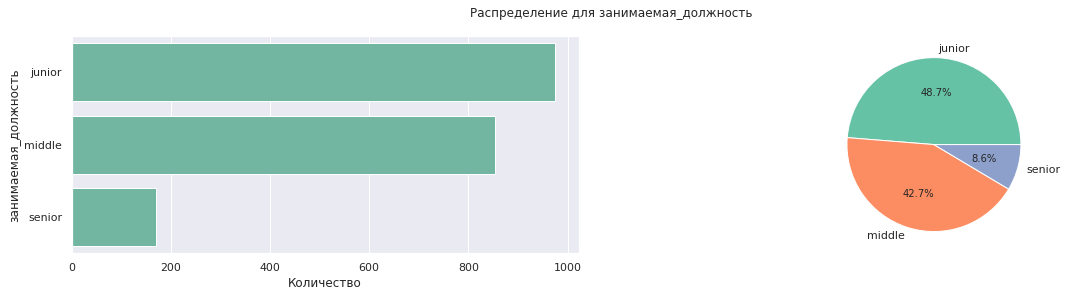

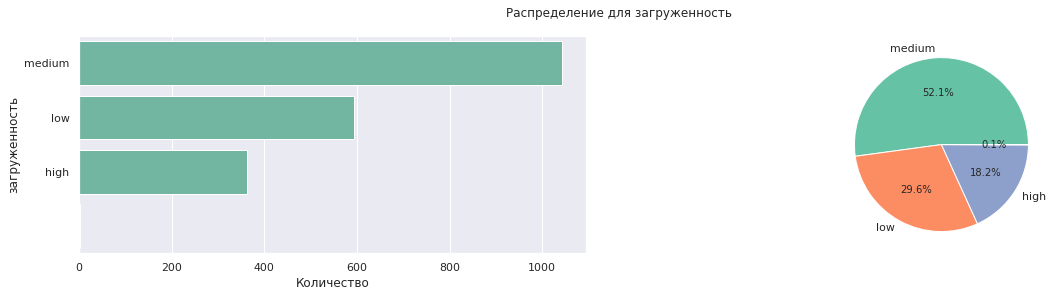

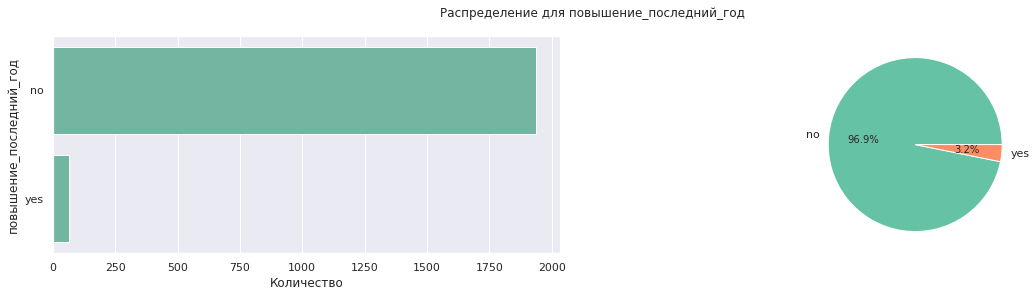

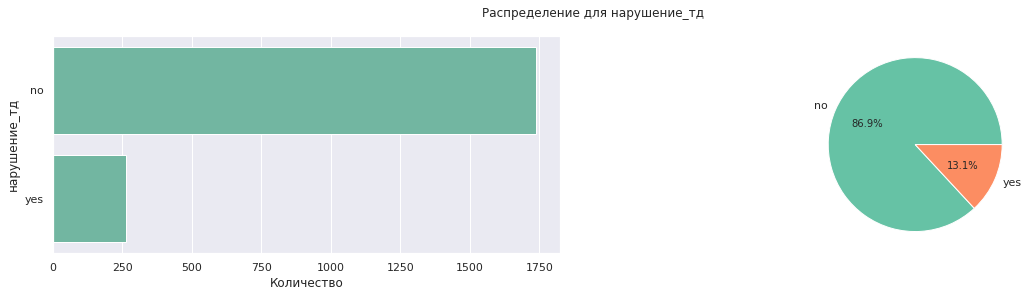

In [32]:
categorial_plot(ts_features, 'Распределение категориальных признаков на тестовой выборке', categorial_features)

Для категориальных признаков можно выделить те же закономерности, что и для тренировочной выборки, однако в данных присутствуют пропуски, которые мы заполним при помощи пайплайна.

#### Корреляционный анализ

Для поиска зависимостей построим матрицы корреляции - это поможет нам проанализировать работу модели и проверить параметры на мультиколлинеарность

In [33]:
tr_satisfaction.drop(columns='id').corr(method='spearman', numeric_only=True)

employment_years  supervisor_evaluation    salary  \
employment_years               1.000000              -0.001554  0.472688   
supervisor_evaluation         -0.001554               1.000000  0.003534   
salary                         0.472688               0.003534  1.000000   
job_satisfaction_rate          0.218589               0.746608  0.126707   

                       job_satisfaction_rate  
employment_years                    0.218589  
supervisor_evaluation               0.746608  
salary                              0.126707  
job_satisfaction_rate               1.000000

In [34]:
numeric_columns_сorr = ['salary',
                        'job_satisfaction_rate']

In [35]:
def correlation_matrix(df: pd.DataFrame, columns: list, df_name: str) -> None:
    fig, axes = plt.subplots(2, 1, figsize=(12, 16))

    sns.heatmap(df.drop(columns='id').corr(method='spearman', numeric_only=True), 
                annot=True, 
                cmap='seismic', 
                fmt=".2f", 
                ax=axes[0])
    axes[0].set_title(f'Матрица корреляции количественных признаков для датафрейма {df_name} по методу Спирмена')
    
    ax = sns.heatmap(df.drop(columns='id').phik_matrix(interval_cols=numeric_columns_сorr), 
                     cmap='seismic', 
                     annot=True, 
                     fmt=".1f", 
                     linewidth=.5, 
                     ax=axes[1])  
    ax.set_title(f'Матрица кореляции для всех признаков датафрейма {df_name}')

    plt.tight_layout()

Используем также библиотеку phik и построим матрицу корреляций для наших значений

**Для тренировочной выборки**

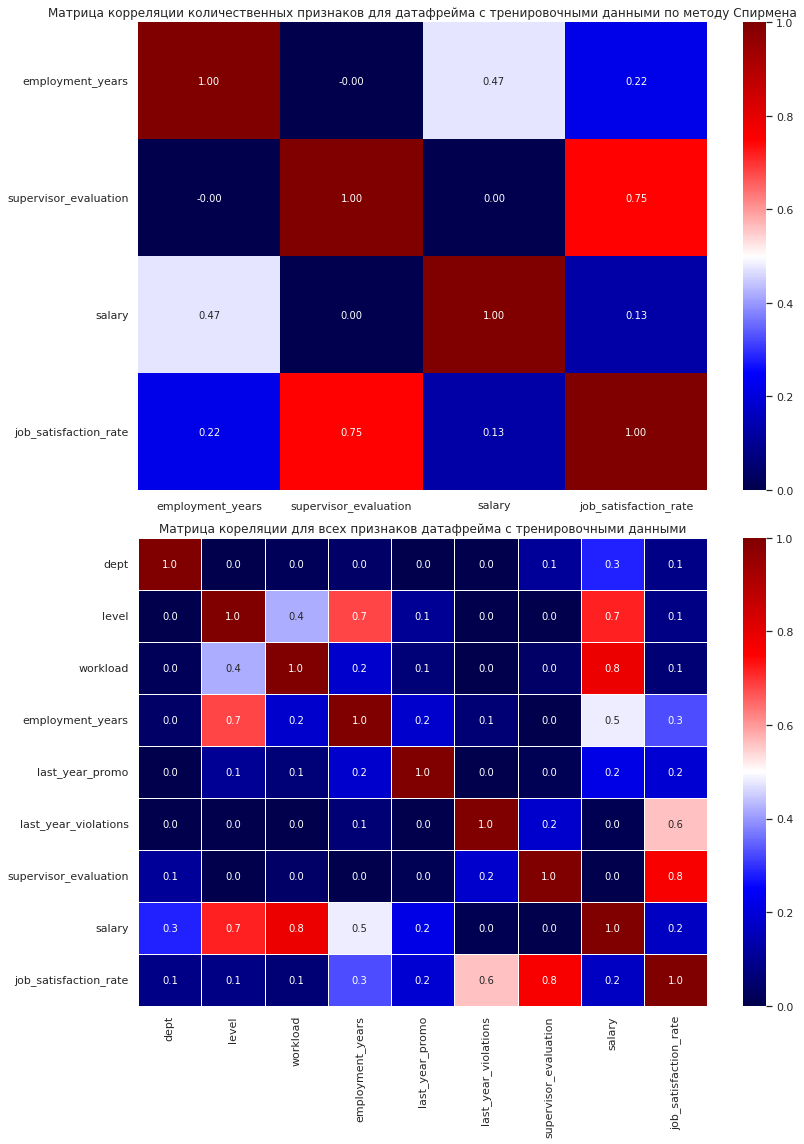

In [36]:
correlation_matrix(tr_satisfaction, numeric_columns_сorr, 'с тренировочными данными')

Можно отметить, что `salary` имеет сильную корреляцию с признаками `level`, `workload`, однако мультиколлинеарности в данных не обнаружено

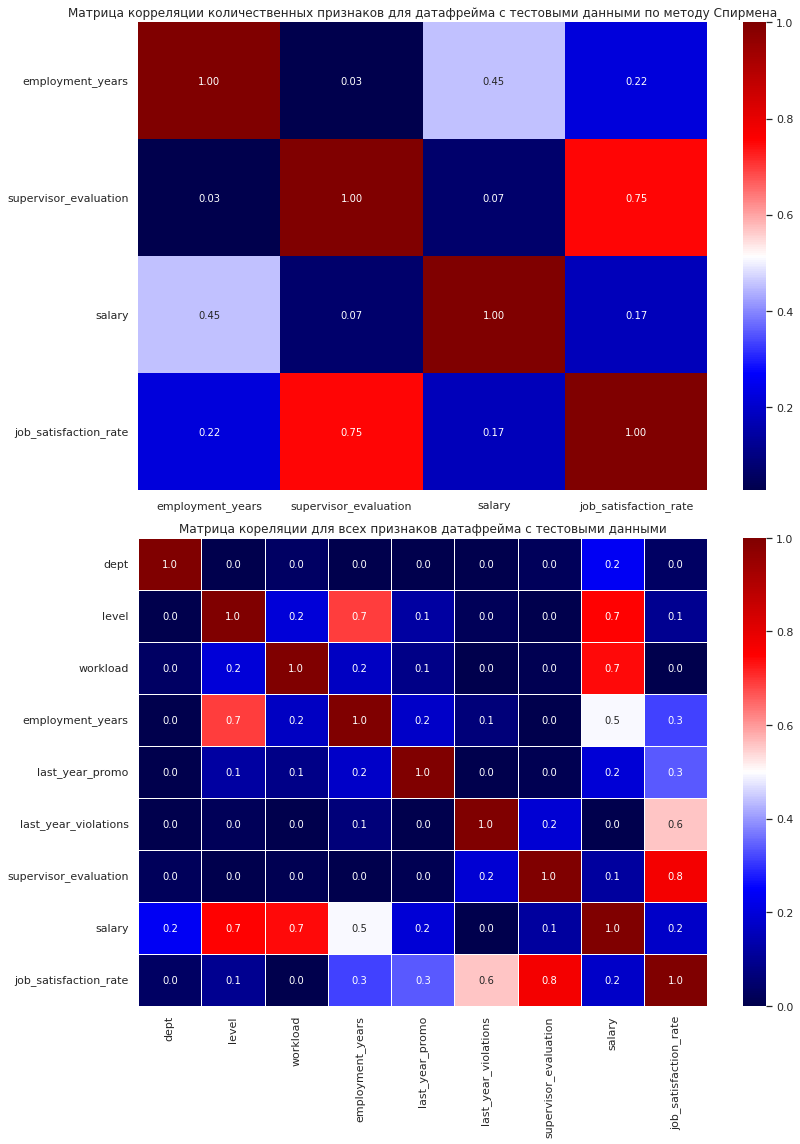

In [37]:
correlation_matrix(ts_features.merge(ts_target, on='id', how='inner'), numeric_columns_сorr, 'с тестовыми данными')

Аналогичный вывод можно сделать и для тестовой выборки: мультиколлинеарности в данных нет, сохраняются те же зависимости, что и для тренировочной выборки

#### Графики распределений для тренировочной выборки

Для оценки зависимостей построим также графики зависимостей количественных переменных друг от друга

In [38]:
numerical_features_plot = numerical_features.copy()
numerical_features_plot['job_satisfaction_rate'] = 'Удовлетворенность работой'

In [39]:
numerical_features

{'employment_years': 'длительность_работы',
 'salary': 'зарплата',
 'supervisor_evaluation': 'оценка_работы'}

In [40]:
numerical_features_plot

{'employment_years': 'длительность_работы',
 'salary': 'зарплата',
 'supervisor_evaluation': 'оценка_работы',
 'job_satisfaction_rate': 'Удовлетворенность работой'}

In [41]:
def plot_correlation(df: pd.DataFrame, field: str = 'last_year_promo', 
                     signs: dict = numerical_features_plot) -> None:
    feature_combinations = combinations(signs.keys(), 2)
    num_plots = len(list(feature_combinations))
    
    num_cols = min(num_plots, 2)  
    num_rows = (num_plots - 1) // 2 + 1  
    figure, axes = plt.subplots(num_rows, num_cols, figsize=(6*num_cols, 4*num_rows))
    
    row_idx, col_idx = 0, 0
    for feat1, feat2 in combinations(signs.keys(), 2):
        ax = axes[row_idx, col_idx]
        sns.scatterplot(data=df, x=feat1, y=feat2, hue=field, ax=ax)
        ax.set_xlabel(signs[feat1])
        ax.set_ylabel(signs[feat2])
        ax.set_title(f'{signs[feat1]} vs {signs[feat2]}')
        
        col_idx += 1
        if col_idx == num_cols:
            row_idx += 1
            col_idx = 0
    
    plt.tight_layout()

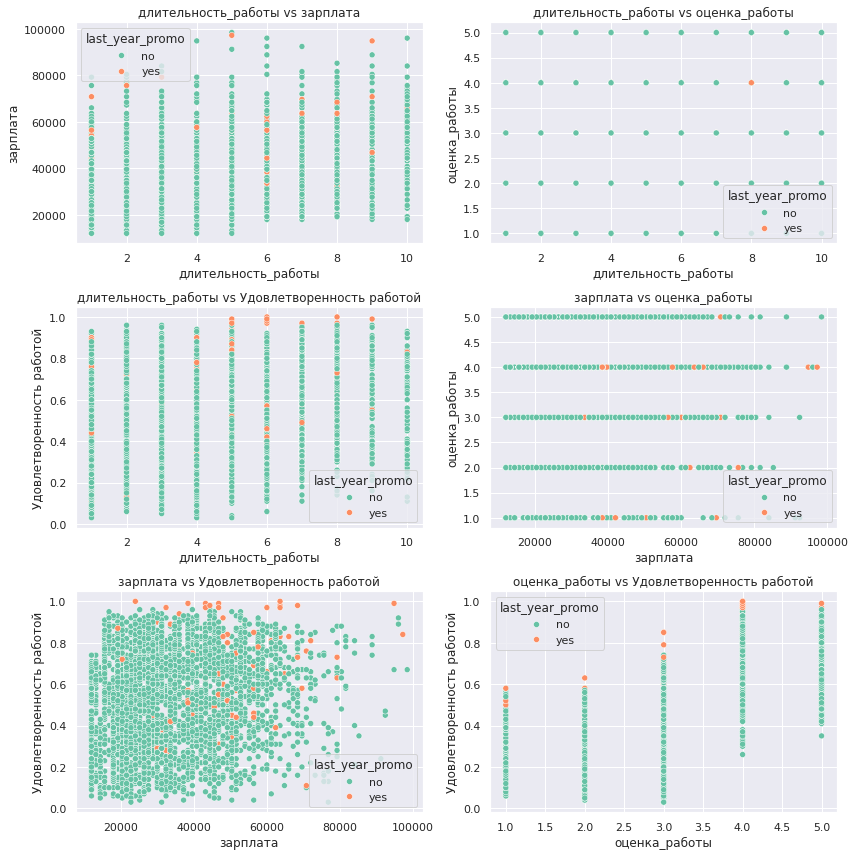

In [42]:
plot_correlation(tr_satisfaction)

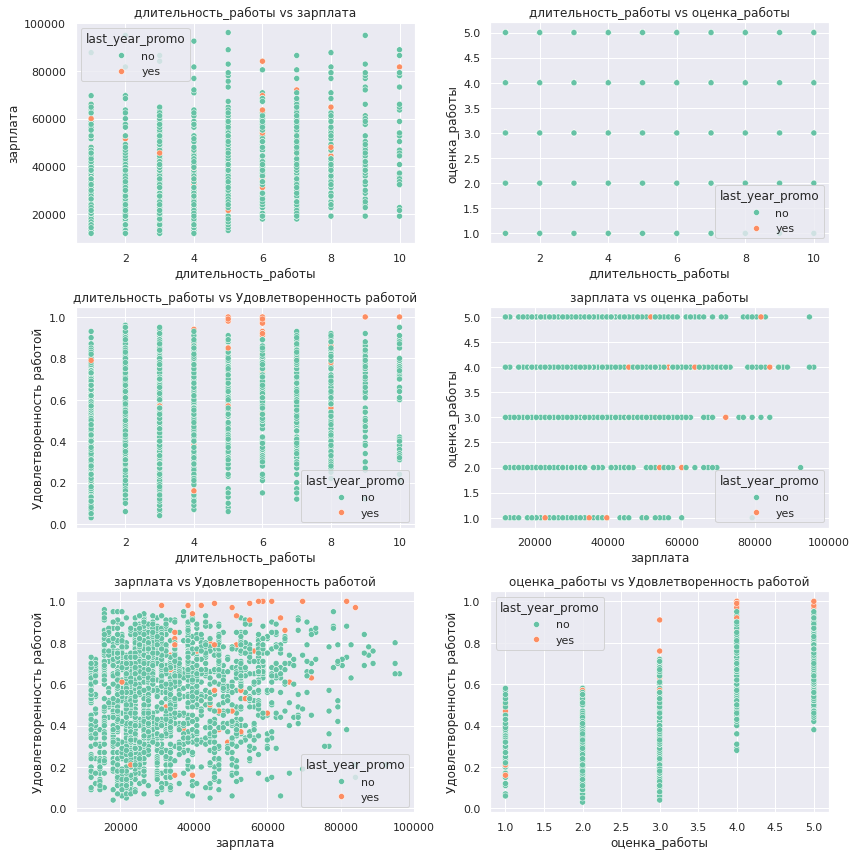

In [43]:
plot_correlation(ts_features.merge(ts_target, on='id', how='inner'), signs=numerical_features_plot)

На графиках корреляции можно отметить, что ни для тренировочной, ни для тестовой выборки нет линейной зависимости между данными

#### Неполные дубликаты в тренировочной и тестовой выборках

Рассмотрим какое количество данных совпадает, если мы обезличим данные - уберем `id` сотрудника

In [44]:
tr_satisfaction.drop(columns='id').duplicated().sum()

245

Посмотрим на полные данные и рассмотрим какое количество от этих данные составляют различные отделы и какой опыт (`level`) у данных сотрудников

In [45]:
(
    tr_satisfaction[
        (
            tr_satisfaction
            .drop(columns='id')
            .duplicated(keep=False)
        )
    ]
     .sort_values(by=['job_satisfaction_rate', 'salary'])
     .head(10)
)

id        dept   level workload  employment_years last_year_promo  \
2956  806591   marketing  junior   medium                 1              no   
3889  660840   marketing  junior   medium                 1              no   
1384  697290       sales  junior      low                 1              no   
2145  732263       sales  junior      low                 1              no   
2245  123843       sales  junior   medium                 1              no   
2571  810844       sales  junior   medium                 1              no   
2856  641547          hr  junior      low                 1              no   
3594  769289          hr  junior      low                 1              no   
1075  695634  technology  junior   medium                 1              no   
1214  826578  technology  junior   medium                 1              no   

     last_year_violations  supervisor_evaluation  salary  \
2956                  yes                      3   26400   
3889                  yes                      3   26400   
1384                  yes                      3   12000   
2145                  yes                      3   12000   
2245                  yes                      3   20400   
2571                  yes                      3   20400   
2856                   no                      3   13200   
3594                   no                      3   13200   
1075                   no                      3   26400   
1214                   no                      3   26400   

      job_satisfaction_rate  
2956                   0.08  
3889                   0.08  
1384                   0.09  
2145                   0.09  
2245                   0.09  
2571                   0.09  
2856                   0.13  
3594                   0.13  
1075                   0.15  
1214                   0.15

Чтобы оценить, насколько это встречающиеся категории, рассмотрим какое количество сотрудников находятся в этих отделах и с этим уровнем занимаемой должности

In [46]:
duplicates = (
    tr_satisfaction[
    (
        tr_satisfaction
        .drop(columns='id')
        .duplicated()
    )
    ]
    .value_counts(subset=['dept', 'level'])
    .reset_index(name='duplicated_count'))

duplicates = duplicates.join(
    tr_satisfaction.value_counts(subset=['dept', 'level']), 
    on=['dept', 'level']
)
duplicates['percent'] = round(duplicates['duplicated_count'] / duplicates['count'] * 100, 1)
duplicates

dept   level  duplicated_count  count  percent
0        sales  junior               102    697     14.6
1   technology  junior                40    410      9.8
2        sales  middle                35    682      5.1
3   purchasing  junior                22    293      7.5
4    marketing  junior                18    270      6.7
5           hr  junior                13    218      6.0
6   technology  middle                 8    380      2.1
7           hr  middle                 3    193      1.6
8   purchasing  middle                 2    262      0.8
9    marketing  middle                 1    227      0.4
10       sales  senior                 1    129      0.8

Проведем аналогичное исследование для тестовых данных

In [47]:
ts_features.drop(columns='id').duplicated().sum()

557

In [48]:
duplicates_ts = (
    ts_features[
    (
        ts_features
        .drop(columns='id')
        .duplicated()
    )
    ]
    .value_counts(subset=['dept', 'level'])
    .reset_index(name='duplicated_count'))

duplicates_ts = duplicates_ts.join(
    ts_features.value_counts(subset=['dept', 'level']), 
    on=['dept', 'level']
)
duplicates_ts['percent'] = round(
    duplicates_ts['duplicated_count'] / duplicates_ts['count'] * 100, 1
)
duplicates_ts

dept   level  duplicated_count  count  percent
0        sales  junior               210    375     56.0
1   technology  junior               100    217     46.1
2        sales  middle                82    324     25.3
3   purchasing  junior                39    134     29.1
4           hr  junior                38    117     32.5
5    marketing  junior                31    129     24.0
6   technology  middle                20    188     10.6
7    marketing  middle                15    131     11.5
8   purchasing  middle                 8    119      6.7
9        sales  senior                 7     63     11.1
10          hr  middle                 6     91      6.6
11  technology  senior                 1     50      2.0

Поскольку эти данные выглядят вполне закономерно - большому отделу соответствует большее количество дубликатов и их можно объяснить предположениями - одинаковые команды, похожие задачи, следовательно аналогичные входные и выходные данные.

**Вывод:**
- Для количественных признаков:
    - Среди распределений количественных данных нет нормального распределения.
    - Для длительности работы мода - 1 год работы и далее количество сотрудников уменьшается с количеством года
    - Наиболее часто ставят оценку 4, потом 3 и далее 5, 2 и 1 по убыванию. Однако количество проставления единиц мало по сравнению с другими оценками - в тренировочных данных 200 единиц на 4000 данных.
    - Зарплаты выше 80 тыс рублей считаются статистическими выбросами, однако это вполне могут быть зарплатами руководителей
- Для категориальных признаков:
    - На основе построенных графиков и статистических значений, самый популярный отдел - sales, в тренировочной выборке в нем работает 1512 сотрудников
    - Большую часть сотрудников составляют джуны и мидлы - их 47,4% и 43,6% соответственно
    - Для большинства сотрудников загруженность на работе на среднем уровне - это 51,6%, далее сотрудники оценили нагрузку как низкую - 30% и высокой она оказалась для 18,4% - примерно 750 человек
    - За последний год повышение получили только 3% сотрудников
    - 14% или 559 человек из тренировочной нарушили трудовой договор за последний год
- был проведен корреляционный анализ, в ходе которого мультиколлинеарности в данных не было обнаружено
- При обезличивании данных обнаружены дубликаты - для тренировочной 245 и 554 для тестовой. Было рассмотрено к каким отделам и уровню занимаемой должности эти дубликаты относятся и было принято решение для тестовой их оставить. Также для тестовых данных их оказалось больше, поскольку в этом датафрейме вынесен таргет в отдельный датафрейм

### Шаг 4. Подготовка данных

Подготовку признаков выполним в пайплайне, дополнив пайплайн шага предобработки. При кодировании учтем особенности признаков и моделей.

In [49]:
tr_unique = tr_satisfaction.set_index('id').drop_duplicates()
ts_all = ts_features.merge(ts_target, on='id', how='inner')

In [50]:
X_train = tr_unique.drop(columns=['job_satisfaction_rate'])
y_train = tr_unique['job_satisfaction_rate']

X_test = ts_all.set_index('id').drop(columns=['job_satisfaction_rate'])
y_test = ts_all['job_satisfaction_rate']

In [51]:
ord_col = ['workload', 'level']
ohe_col = ['dept', 'last_year_promo', 'last_year_violations']
num_cols = ['employment_years', 'salary']

In [52]:
pipe_ord = Pipeline([
    ('SimpleImputer_before', SimpleImputer(missing_values=np.nan, 
                                           strategy='most_frequent')),
    ('SimpleImputer_str', SimpleImputer(missing_values=' ',
                                        strategy='constant',
                                        fill_value=np.nan)),
    ('SimpleImputer_again', SimpleImputer(missing_values=np.nan, 
                                           strategy='most_frequent')),
    ('ord_encoder', OrdinalEncoder(categories=[['low', 'medium', 'high'], 
                                               ['junior', 'middle', 'senior']], 
                                   handle_unknown='use_encoded_value', 
                                   unknown_value=np.nan)),
    ('SimpleImputer_after', SimpleImputer(missing_values=np.nan, 
                                           strategy='most_frequent')),
])


pipe_ohe = Pipeline([
    ('SimpleImputer', SimpleImputer(missing_values=np.nan, 
                                    strategy='most_frequent')),
    ('SimpleImputer_str', SimpleImputer(missing_values=' ',
                                        strategy='constant',
                                        fill_value=np.nan)),
    ('SimpleImputer_again', SimpleImputer(missing_values=np.nan, 
                                           strategy='most_frequent')),
    ('hot_encoder', OneHotEncoder(handle_unknown='ignore', 
                                  drop='first')),
])

pipe_scaler = Pipeline([
    ('SimpleImputer_num', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    [
        ('ohe', pipe_ohe, ohe_col),
        ('ord', pipe_ord, ord_col),
        ('scaler', pipe_scaler, num_cols)
        ], 
    remainder='passthrough')

pipe_final = Pipeline([
    ('preprocessor', preprocessor),
    ('models', Ridge(random_state=RANDOM_STATE))
])

In [53]:
pipe_final

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('SimpleImputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('SimpleImputer_str',
                                                                   SimpleImputer(fill_value=nan,
                                                                                 missing_values=' ',
                                                                                 strategy='constant')),
                                                                  ('SimpleImputer_again',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('hot_encoder',
                                                                   OneHotEncode...
                                                                                              ['junior',
                                                                                               'middle',
                                                                                               'senior']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('SimpleImputer_after',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['workload', 'level']),
                                                 ('scaler',
                                                  Pipeline(steps=[('SimpleImputer_num',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['employment_years',
                                                   'salary'])])),
                ('models', Ridge(random_state=5))])

### Шаг 5. Обучение моделей

1. Обучение моделей: 
   - Обучим две модели: одну линейную и одну модель на основе дерева решений.
   - Проведём настройку гиперпараметров для каждой из моделей, используя известные методы, такие как кросс-валидация или сеточный поиск.

2. Оценка моделей:
   - Выберем лучшую модель, основываясь на метрике SMAPE (symmetric mean absolute percentage error).
   - Вычислим SMAPE для каждой модели с использованием написанной функции, которая принимает на вход массивы NumPy или объекты Series из pandas и возвращает значение метрики.

Метрика SMAPE вычисляется так:

$$\mathrm{SMAPE} = \frac {100} n \sum_{i=1}^n \frac{|y_i - \hat{y_i}|} {(|y_i| + |\hat y_i|) / 2}$$

где:
- $y_i​$ — фактическое значение целевого признака для объекта с порядковым номером i в выборке;
- $\hat{y_i}$​ — предсказанное значение целевого признака для объекта с порядковым номером i в выборке;
- n — количество объектов в выборке;
- $\sum_{i=1}^n$​ — сумма значений, полученная в результате операций, которые следуют за этим знаком, для всех объектов с порядковым номером от i до n в выборке.

In [54]:
def smape_score(y_test, y_pred):
    n = y_pred.shape[0]
    absolute_diff = np.abs(y_test - y_pred)
    sum_absolute = np.abs(y_test) + np.abs(y_pred)
    
    smape = 100 / n * np.sum(absolute_diff / (sum_absolute / 2))
    return smape
    
score = make_scorer(score_func=smape_score, greater_is_better=False)

In [55]:
params_grid = [
    {
        'models': [Ridge(random_state=RANDOM_STATE)],
        'models__alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
        'models__fit_intercept': [True, False],
        'models__solver': ['auto', 'svd', 'saga'],
        'preprocessor__scaler': [MinMaxScaler(), StandardScaler(), 'passthrough']
    },
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(5, 15),
        'models__max_features': range(5, 15),
        'preprocessor__scaler': [MinMaxScaler(), StandardScaler(), 'passthrough']
    },
    {
        'models': [Lasso(random_state=RANDOM_STATE)],
        'models__alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
        'models__fit_intercept': [True, False],
        'models__tol': [0.001, 0.01, 0.1],
        'preprocessor__scaler': [MinMaxScaler(), RobustScaler(), StandardScaler(), 'passthrough']
    }
]

In [56]:
gs_search = GridSearchCV(
    pipe_final, 
    params_grid, 
    cv=5,
    scoring=score,
    n_jobs=-1,
)
gs_search.fit(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('SimpleImputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('SimpleImputer_str',
                                                                                          SimpleImputer(fill_value=nan,
                                                                                                        missing_values=' ',
                                                                                                        strategy='constant')),
                                                                                         ('SimpleImputer_again',
                                                                                          SimpleImputer(strategy='most_frequent'))...
                          'preprocessor__scaler': [MinMaxScaler(),
                                                   StandardScaler(),
                                                   'passthrough']},
                         {'models': [Lasso(random_state=5)],
                          'models__alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
                          'models__fit_intercept': [True, False],
                          'models__tol': [0.001, 0.01, 0.1],
                          'preprocessor__scaler': [MinMaxScaler(),
                                                   RobustScaler(),
                                                   StandardScaler(),
                                                   'passthrough']}],
             scoring=make_scorer(smape_score, greater_is_better=False))

In [57]:
best_decision = gs_search.best_estimator_
best_model = best_decision.named_steps['models']
best_params = gs_search.best_params_

In [58]:
pd.DataFrame(gs_search.cv_results_).sort_values(by='rank_test_score', ascending=True).head(5)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
375       0.032261      0.000427         0.010060        0.000309   
372       0.032513      0.000818         0.010027        0.000271   
366       0.032607      0.001514         0.009946        0.000578   
369       0.031511      0.000237         0.009684        0.000125   
345       0.033497      0.001162         0.010434        0.000255   

                                          param_models param_models__alpha  \
375  DecisionTreeRegressor(max_depth=13, max_featur...                 NaN   
372  DecisionTreeRegressor(max_depth=13, max_featur...                 NaN   
366  DecisionTreeRegressor(max_depth=13, max_featur...                 NaN   
369  DecisionTreeRegressor(max_depth=13, max_featur...                 NaN   
345  DecisionTreeRegressor(max_depth=13, max_featur...                 NaN   

    param_models__fit_intercept param_models__solver  \
375                         NaN                  NaN   
372                         NaN                  NaN   
366                         NaN                  NaN   
369                         NaN                  NaN   
345                         NaN                  NaN   

    param_preprocessor__scaler param_models__max_depth  ... param_models__tol  \
375             MinMaxScaler()                      13  ...               NaN   
372             MinMaxScaler()                      13  ...               NaN   
366             MinMaxScaler()                      13  ...               NaN   
369             MinMaxScaler()                      13  ...               NaN   
345             MinMaxScaler()                      12  ...               NaN   

                                                params split0_test_score  \
375  {'models': DecisionTreeRegressor(max_depth=13,...        -15.415676   
372  {'models': DecisionTreeRegressor(max_depth=13,...        -15.415676   
366  {'models': DecisionTreeRegressor(max_depth=13,...        -15.415676   
369  {'models': DecisionTreeRegressor(max_depth=13,...        -15.415676   
345  {'models': DecisionTreeRegressor(max_depth=13,...        -15.461479   

     split1_test_score  split2_test_score  split3_test_score  \
375         -14.891609         -16.233415         -16.515937   
372         -14.891609         -16.233415         -16.515937   
366         -14.891609         -16.233415         -16.515937   
369         -14.891609         -16.233415         -16.515937   
345         -14.657385         -16.511384         -16.723223   

     split4_test_score  mean_test_score  std_test_score  rank_test_score  
375         -15.381805       -15.687688        0.597513                1  
372         -15.381805       -15.687688        0.597513                1  
366         -15.381805       -15.687688        0.597513                1  
369         -15.381805       -15.687688        0.597513                1  
345         -15.174862       -15.705667        0.790554                5  

[5 rows x 21 columns]

In [59]:
print('Лучшая модель и её параметры:\n\n', gs_search.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('SimpleImputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('SimpleImputer_str',
                                                                   SimpleImputer(fill_value=nan,
                                                                                 missing_values=' ',
                                                                                 strategy='constant')),
                                                                  ('SimpleImputer_again',
                                                                   SimpleImputer(strategy='most_frequent')),
                                    

In [60]:
print(f'Метрика SMAPE лучшей модели по кросс-валидации на обучающих данных: {round(gs_search.best_score_,4) * (-1)}')

Метрика SMAPE лучшей модели по кросс-валидации на обучающих данных: 15.6877


Теперь используем модель на тестовых данных, полученных от заказчика

In [61]:
y_pred = gs_search.predict(X_test)
smape_test = smape_score(y_test, y_pred)
print(f'Метрика SMAPE лучшей модели на тестовых данных {round(smape_test, 4)}')

Метрика SMAPE лучшей модели на тестовых данных 14.3712


In [62]:
gs_search.best_estimator_.steps

[('preprocessor',
  ColumnTransformer(remainder='passthrough',
                    transformers=[('ohe',
                                   Pipeline(steps=[('SimpleImputer',
                                                    SimpleImputer(strategy='most_frequent')),
                                                   ('SimpleImputer_str',
                                                    SimpleImputer(fill_value=nan,
                                                                  missing_values=' ',
                                                                  strategy='constant')),
                                                   ('SimpleImputer_again',
                                                    SimpleImputer(strategy='most_frequent')),
                                                   ('hot_encoder',
                                                    OneHotEncoder(drop='first',
                                                                  handle_unknown='i...

In [63]:
best_decision['preprocessor'].transformers_[0][1][3].get_feature_names_out()

array(['x0_marketing', 'x0_purchasing', 'x0_sales', 'x0_technology',
       'x1_yes', 'x2_yes'], dtype=object)

In [64]:
feature_names_ohe = list(best_decision['preprocessor'].transformers_[0][1][3].get_feature_names_out())
feature_names_ohe_with_values = feature_names_ohe[:4]

for num, col_name in enumerate(ohe_col[1:], start=1):
    feature_names_ohe_with_values.append(f"{feature_names_ohe[num + 3]}_{col_name}")

In [65]:
feature_names_ohe_with_values

['x0_marketing',
 'x0_purchasing',
 'x0_sales',
 'x0_technology',
 'x1_yes_last_year_promo',
 'x2_yes_last_year_violations']

In [66]:
feature_names = feature_names_ohe_with_values + ord_col + num_cols + ['supervisor_evaluation']

#### Визуализация с помощью shap

In [67]:
best_decision.named_steps

{'preprocessor': ColumnTransformer(remainder='passthrough',
                   transformers=[('ohe',
                                  Pipeline(steps=[('SimpleImputer',
                                                   SimpleImputer(strategy='most_frequent')),
                                                  ('SimpleImputer_str',
                                                   SimpleImputer(fill_value=nan,
                                                                 missing_values=' ',
                                                                 strategy='constant')),
                                                  ('SimpleImputer_again',
                                                   SimpleImputer(strategy='most_frequent')),
                                                  ('hot_encoder',
                                                   OneHotEncoder(drop='first',
                                                                 handle_unknown='i...
              

In [68]:
best_decision.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('SimpleImputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('SimpleImputer_str',
                                                                   SimpleImputer(fill_value=nan,
                                                                                 missing_values=' ',
                                                                                 strategy='constant')),
                                                                  ('SimpleImputer_again',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('hot_encoder',
                                                                   OneHotEncode...
                                                                   OrdinalEncoder(categories=[['low',
                                                                                               'medium',
                                                                                               'high'],
                                                                                              ['junior',
                                                                                               'middle',
                                                                                               'senior']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('SimpleImputer_after',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['workload', 'level']),
                                                 ('scaler', MinMaxScaler(),
                                                  ['employment_years',
                                                   'salary'])])),
                ('models',
                 DecisionTreeRegressor(max_depth=13, max_features=11,
                                       random_state=5))])

In [69]:
x_Train = pd.DataFrame(best_decision['preprocessor'].fit_transform(X_train),
                      columns=feature_names)

x_Test = pd.DataFrame(best_decision['preprocessor'].transform(X_test),
                     columns=feature_names)

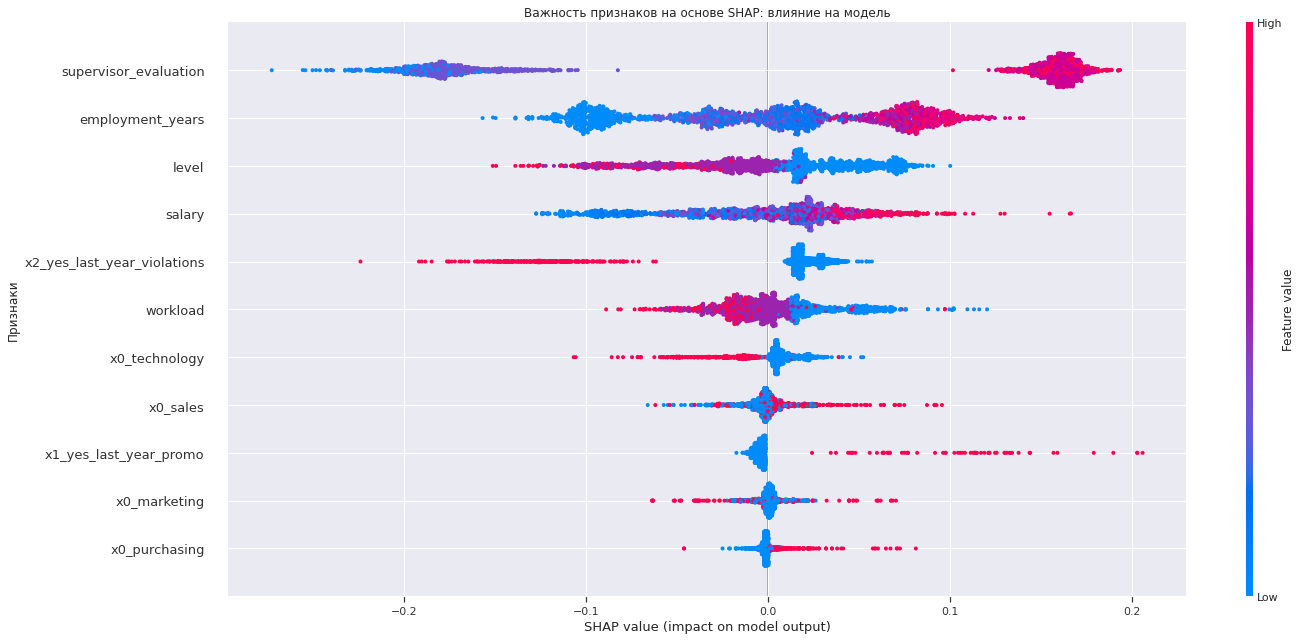

In [70]:
ex = shap.TreeExplainer(best_model)
shap_values = ex.shap_values(x_Test)

plt.title('Важность признаков на основе SHAP: влияние на модель')
plt.ylabel('Признаки');
shap.summary_plot(shap_values, x_Test, plot_size=(20,9))

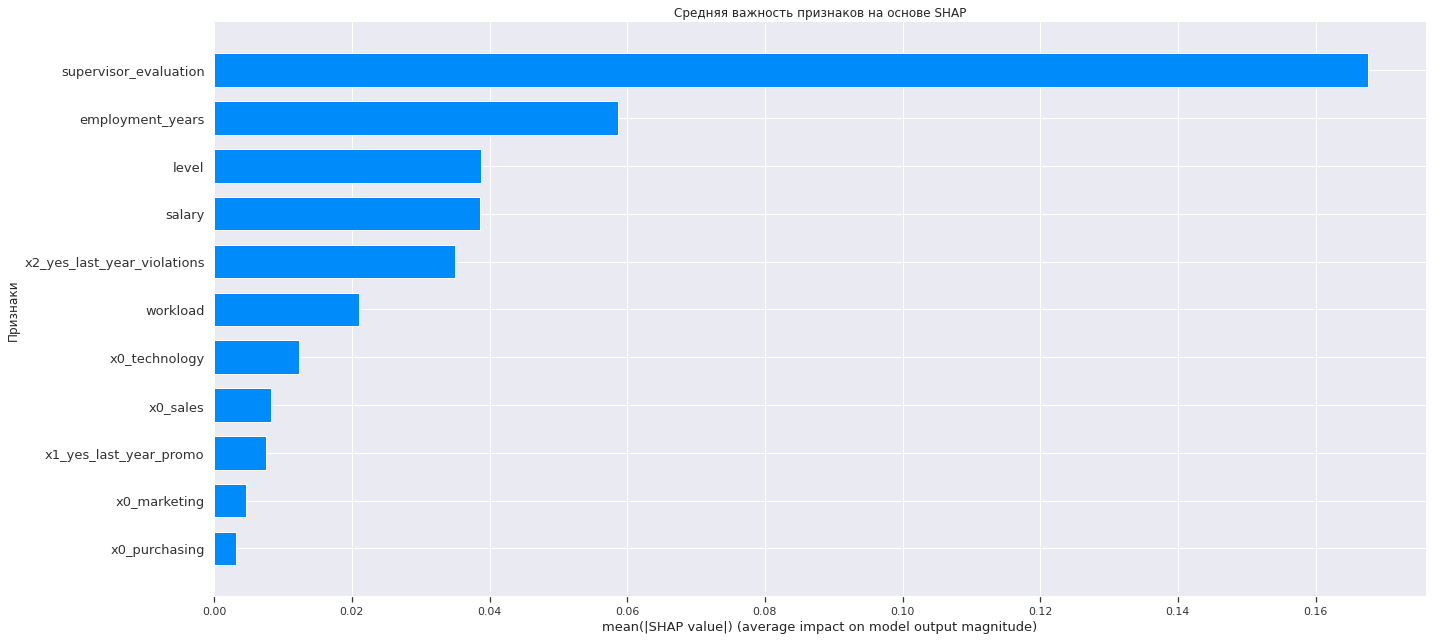

In [71]:
plt.title('Средняя важность признаков на основе SHAP')
plt.ylabel('Признаки');
shap.summary_plot(shap_values, x_Test, plot_type='bar', plot_size=(20,9))

In [72]:
title = "Силовой график SHAP: Влияние особенностей на прогнозирование модели"
title_length = len(title)
print(f"{title:^{title_length + 40}}")
shap.force_plot(ex.expected_value, shap_values, x_Test)

                    Силовой график SHAP: Влияние особенностей на прогнозирование модели                    


### Шаг 6. Оформление выводов

**Вывод**:

- Основное влияние на решение модели относительно уровня удовлетворенности является оценка сотрудника - чем она будет выше, тем больше будет уровень удовлетворенности
- Чем дольше сотрудник работает в компании, тем больше его уровень удовлетворенности компанией, что вполне закономерно
- При нарушении сотрудником трудового договора, его удовлетворенность работой снимажется - этот признак вносит вклад в снижение уровня удовлетворенности
- Так же значительный вклад вносит уровень и уровень загруженности - он вносит вклад в снижение уровня удовлетворенности работы
- Повышение за последний год положительно влияет на уровень удовлетворенности

## Задача 2: предсказание увольнения сотрудника из компании

### Шаг 1. Загрузка данных

Файлы с данными:
- Тренировочная выборка `train_quit.csv`
- Входные признаки тестовой выборки те же, что и в прошлой задаче: `test_features.csv`
- Целевой признак тестовой выборки: `test_target_quit.csv`

In [73]:
if (os.path.exists('./datasets/train_quit.csv') and
    os.path.exists('./datasets/test_target_quit.csv')):
    tr_quit = pd.read_csv('./datasets/train_quit.csv')
    ts_target_quit = pd.read_csv('./datasets/test_target_quit.csv')
    print('Success, local files was read')
    
elif (os.path.exists('/datasets/train_quit.csv') and
      os.path.exists('/datasets/test_target_quit.csv')):
    tr_quit = pd.read_csv('/datasets/train_quit.csv')
    ts_target_quit = pd.read_csv('/datasets/test_target_quit.csv')
    
else:
    print('Something went wrong')

<u>**Тренировочная выборка**</u>

In [74]:
tr_quit.head(10)

id        dept   level workload  employment_years last_year_promo  \
0  723290       sales  middle     high                 2              no   
1  814010       sales  junior   medium                 2              no   
2  155091  purchasing  middle   medium                 5              no   
3  257132       sales  junior   medium                 2              no   
4  910140   marketing  junior   medium                 2              no   
5  699916       sales  junior      low                 1              no   
6  417070  technology  middle   medium                 8              no   
7  165489       sales  middle      low                 4              no   
8  996399   marketing  middle      low                 7              no   
9  613206  technology  middle   medium                 2              no   

  last_year_violations  supervisor_evaluation  salary quit  
0                   no                      4   54000   no  
1                   no                      4   27600   no  
2                   no                      1   37200   no  
3                  yes                      3   24000  yes  
4                   no                      5   25200   no  
5                  yes                      3   18000  yes  
6                   no                      2   44400   no  
7                   no                      5   19200   no  
8                   no                      4   25200   no  
9                   no                      3   45600  yes

In [75]:
get_info(tr_quit)

Info about data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB

Info about missing data:
 id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations   

<u>**Тестовая выборка**</u>

In [76]:
ts_target_quit.head()

id quit
0  999029  yes
1  372846   no
2  726767   no
3  490105   no
4  416898  yes

In [77]:
get_info(ts_target_quit)

Info about data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB

Info about missing data:
 id      0
quit    0
dtype: int64

Info about duplicates:
 0


**Вывод**:

Данные аналогичны данным из первой части работы

### Шаг 2. Предобработка данных

Изучим новые данные - `train_quit.csv`, `test_target_quit.csv`

**<u>Датасет тренировочной выборки, содержащей харакктеристики сотрудников и включающий в себя параметр, показывающий уволился ли сотрудник</u>**

In [78]:
unique_data(tr_quit)

dept: sales (1438), purchasing (928), marketing (588), technology (582), hr (464)
level: middle (1949), junior (1694), sinior (357)
workload: high (2118), medium (1208), low (674)
employment_years: 2 (985), 5 (777), 1 (479), 8 (393), 4 (362), 7 (308), 3 (296), 9 (174), 6 (136), 10 (90)
last_year_promo: no (3887), yes (113)
last_year_violations: no (3455), yes (545)
supervisor_evaluation: 4 (1654), 1 (1233), 3 (520), 5 (391), 2 (202)
quit: no (2872), yes (1128)


In [79]:
tr_quit.shape

(4000, 10)

In [80]:
tr_quit['level'] = tr_quit['level'].replace(['sinior', 'senior'], 'senior')

**<u>Датасет, содержащий в себе таргет - увольнение сотрудника</u>**

In [81]:
unique_data(ts_target_quit)

quit: yes (1436), no (564)


In [82]:
ts_target_quit.shape

(2000, 2)

**Вывод**:
- Тренировочные данные относятся к тестовым данным, как 2:1
- В тренировочных данных представлены те же самые признаки, что и в первом задании

### Шаг 3. Исследовательский анализ данных

3.1. Проведите исследовательский анализ данных.

3.2. Составьте портрет «уволившегося сотрудника». Например, можно узнать, в каком отделе с большей вероятностью работает уволившийся сотрудник и какой у него уровень загруженности. Также можно сравнить среднее значение зарплаты ушедших сотрудников с теми, кто остался в компании.

3.3. Аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Проверьте это утверждение: визуализируйте и сравните распределения признака `job_satisfaction_rate` для ушедших и оставшихся сотрудников. Используйте данные с обоими целевыми признаками тестовой выборки.

**<u>Датасет тренировочной выборки, содержащей харакктеристики сотрудников и включающий в себя параметр, показывающий уволился ли сотрудник</u>**

In [83]:
tr_quit[numerical_features.keys()].describe()

employment_years        salary  supervisor_evaluation
count       4000.000000   4000.000000            4000.000000
mean           3.701500  33805.800000               3.474750
std            2.541852  15152.415163               1.004049
min            1.000000  12000.000000               1.000000
25%            2.000000  22800.000000               3.000000
50%            3.000000  30000.000000               4.000000
75%            6.000000  43200.000000               4.000000
max           10.000000  96000.000000               5.000000

Графики количественных признаков для Распределение количественных признаков на тренировочной выборке


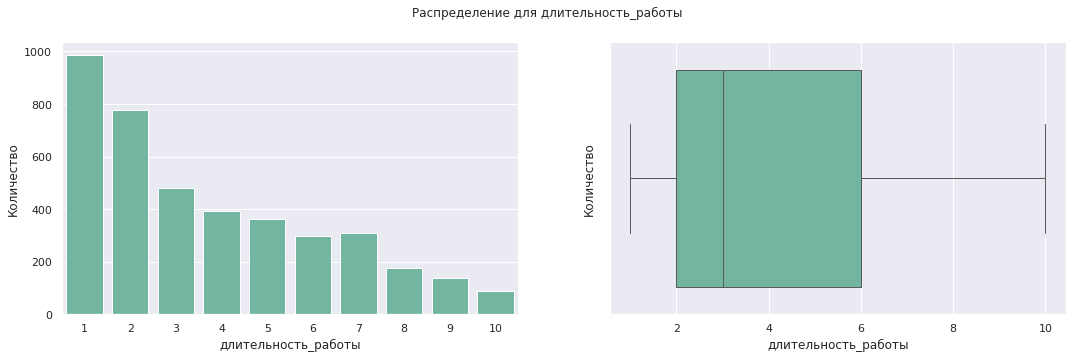

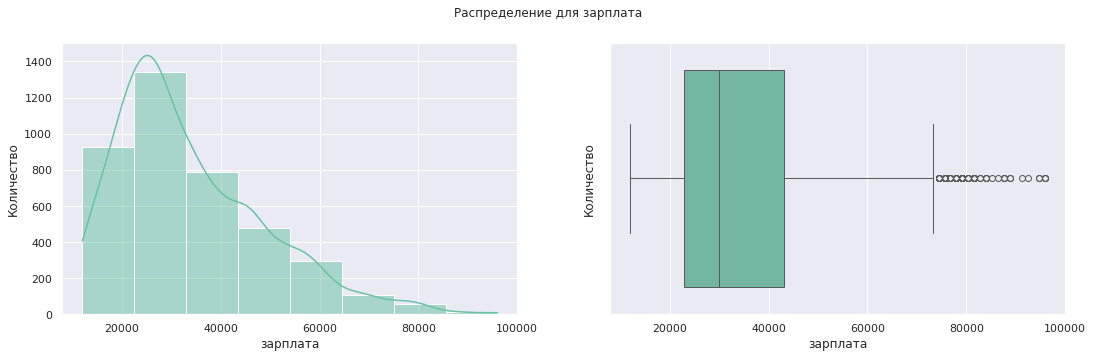

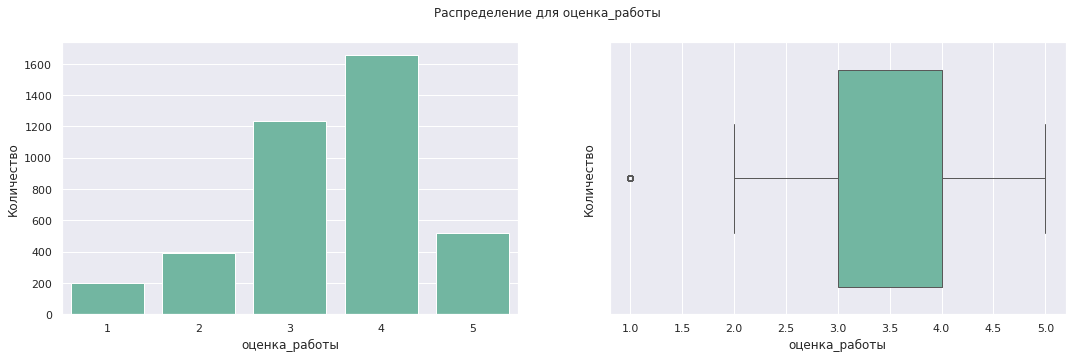

In [84]:
numerical_plot(tr_quit, 'Распределение количественных признаков на тренировочной выборке', numerical_features)

In [85]:
categorial_features['quit'] = 'Увольнение сотрудника'

In [86]:
tr_quit[categorial_features.keys()].describe()

dept   level workload last_year_promo last_year_violations  quit
count    4000    4000     4000            4000                 4000  4000
unique      5       3        3               2                    2     2
top     sales  junior   medium              no                   no    no
freq     1438    1949     2118            3887                 3455  2872

Графики категориальных признаков для Распределение для категориальных признаков


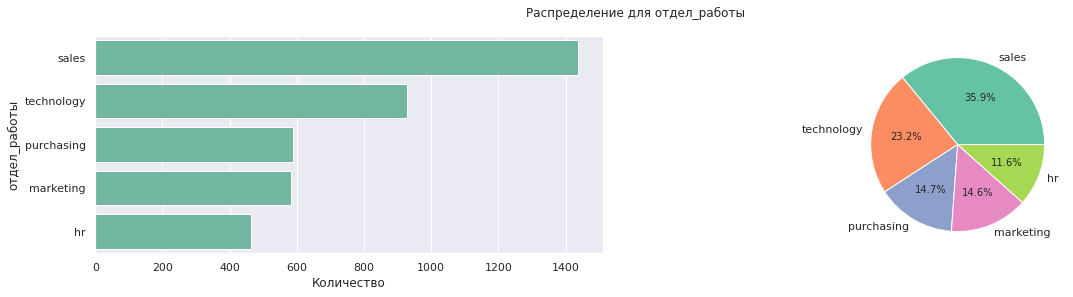

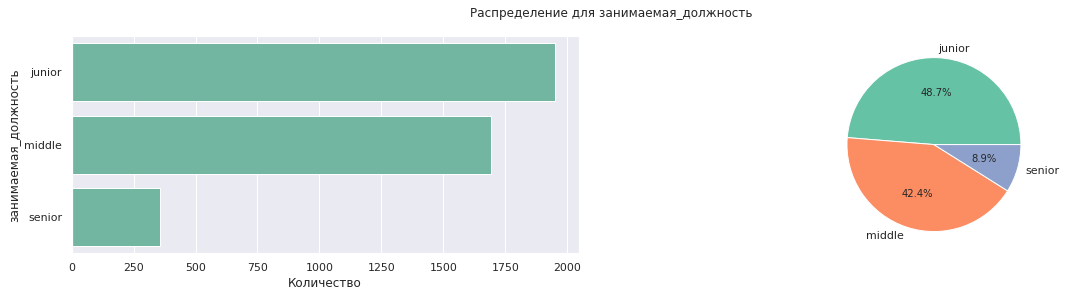

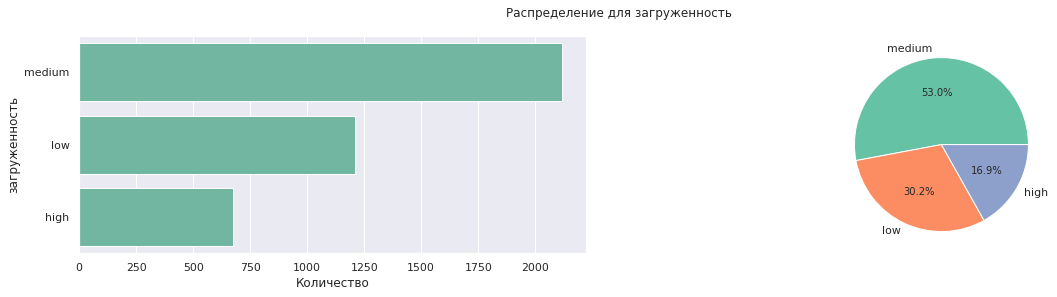

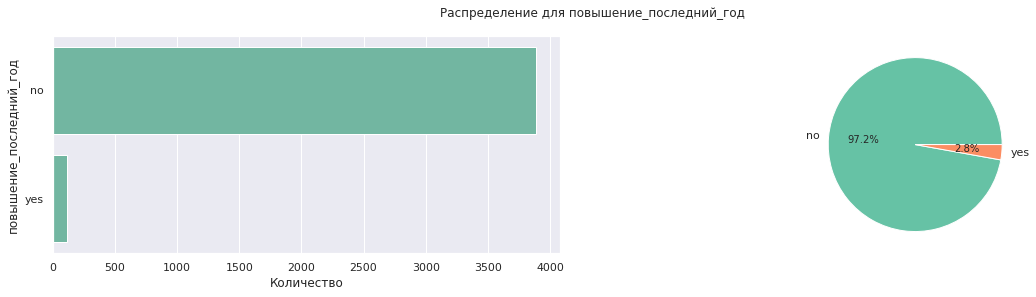

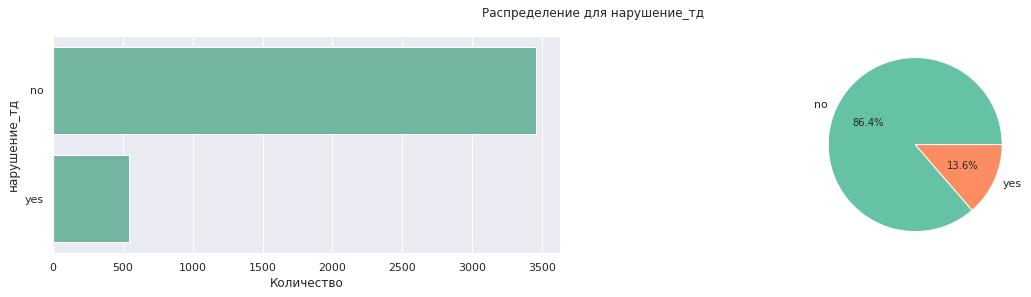

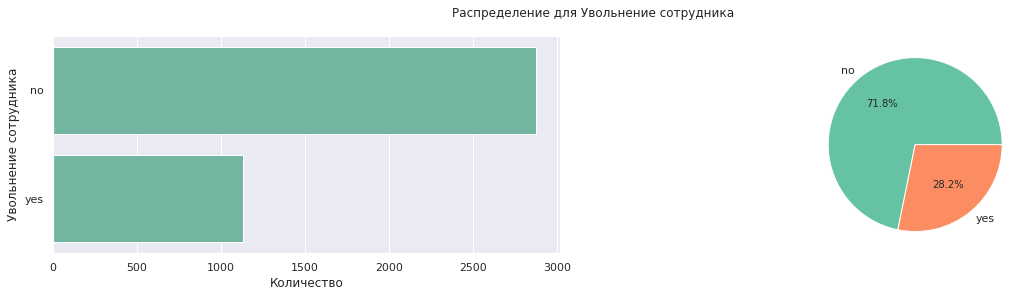

In [87]:
categorial_plot(tr_quit, 'Распределение для категориальных признаков', categorial_features)

**Вывод**
- Для количественных признаков
    - В датасете большее количество сотрудников с опытом работы 1-2 года, соответственно медианное значение между 2 и 3 годами
    - Средняя зарплата 33 тысячи рублей
    - Наиболее частая оценка работы сотрудника - 4
- Для категориальных признаков
    - Больше всего сотрудников из отдела `sales`
    - Самая большая по количеству категория должности - `junior`, а по загруженности - `medium`
    - 2,8 процентов сотрудников из выборки получили повышение, а 13,6% нарушили трудовой договор
    - Чуть больше 28% сотрудников уволились из компании

**Функции для анализа ухода сотрудников**

In [88]:
def categorial_plot_quit(df: pd.DataFrame, title: str, features: dict, sign: str or list = 'quit') -> None:
    '''
    Function for plotting categorical distribution
    params: df: dataframe for research
            title: name for plot title
            features: dict of features to research, keys - eng, values - ru for captions
            sign: column indicating quitting status
    '''
    print(f'Графики категориальных признаков для {title}')

    for feature, feat_ru in features.items():
        data_no = df[df[sign] == "no"][feature].value_counts(normalize=True).reset_index()
        data_yes = df[df[sign] == "yes"][feature].value_counts(normalize=True).reset_index()
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))  
        fig.suptitle(f'Распределение для {feat_ru}')
        
        axes[0].yaxis.grid(True)
        sns.barplot(data=data_no, hue=feature, y='proportion', ax=axes[0], palette='husl')
        axes[0].set_ylabel('Относительные частоты', fontsize=12)
        axes[0].legend(title=feat_ru, fontsize=12)
        axes[0].set_title('Для оставшихся сотрудников')

        axes[1].yaxis.grid(True)
        sns.barplot(data=data_yes, hue=feature, y='proportion', ax=axes[1], palette='Set2')
        axes[1].set_ylabel('Относительные частоты', fontsize=12)
        axes[1].legend(title=feat_ru, fontsize=12)
        axes[1].set_title('Для уволившихся сотрудников')

        axes[2].pie(data_yes['proportion'], labels=data_yes[feature], autopct='%.1f%%', radius=1)
        axes[2].set_title('Распределение для уволившихся сотрудников')

        plt.tight_layout()

In [89]:
def numerical_plot_quit(df: pd.DataFrame, title: str, features: dict, sign: str or list = 'quit'):
    '''
    function for plotting numerical distribution
    params: df: dataframe for research
            tltle: name for plot title
            features: dict of features to research, keys - eng, values - ru for captions
    '''
    print(f'Графики количественных признаков для {title}')
    
    for feature, feat_ru in features.items():
        fig, axes = plt.subplots(1, 2, figsize=(18, 5))
        if df[feature].dtype == 'int64' and len(df[feature].unique()) < 20:
            
            data_no = df[df[sign] == "no"][feature].value_counts(normalize=True).reset_index()
            data_yes = df[df[sign] == "yes"][feature].value_counts(normalize=True).reset_index()
            sns.barplot(data=data_yes, y='proportion', x=feature, ax=axes[0], color='#FC8D62', alpha=0.75, label='Yes')
            sns.barplot(data=data_no, y='proportion', x=feature, ax=axes[0], color='#66C2A5', label='No', fill=False)
            
        else:
            sns.histplot(data=df, 
                         x=feature, 
                         kde=True, 
                         ax=axes[0], 
                         bins=round(log((len(df[feature].unique()) + 1))*2, ), 
                         hue=sign, 
                         stat='density', 
                         common_norm=False)
        sns.boxplot(data=df, x=feature, ax=axes[1], hue=sign)
        fig.suptitle(f'Распределение для {feat_ru}')
        for num in range(2):
            axes[num].set_ylabel('Проценты')
            axes[num].set_xlabel(feat_ru)

#### Составим портрет "уволившего сотрудника".

Расммотрим в каких отделах, с какой должностью, уровнем загруженностью и были ли наружения тд сотрудники увольнялись больше всего

In [90]:
categories = {'dept': 'отдел_работы',
              'level': 'занимаемая_должность',
              'workload': 'загруженность',
              'last_year_violations': 'нарушение_тд', 
              'last_year_promo': 'повышение_последний_год'}

Графики категориальных признаков для Составление портрета уволившегося сотрудника


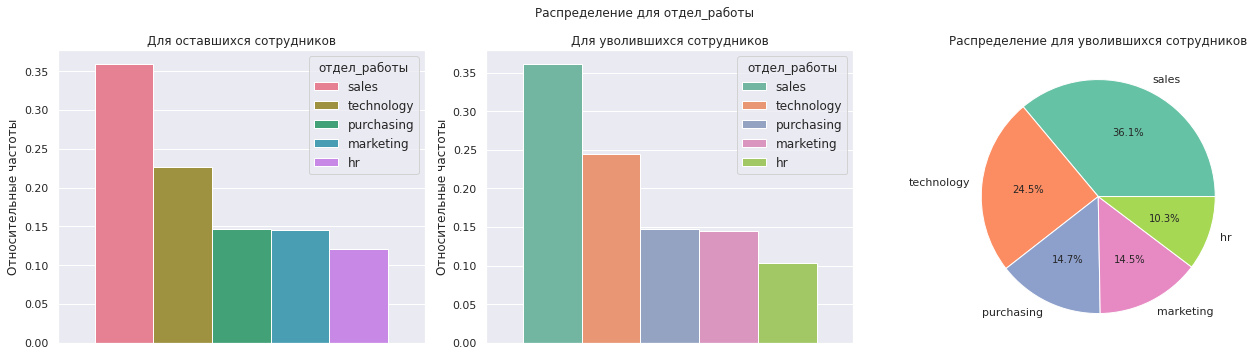

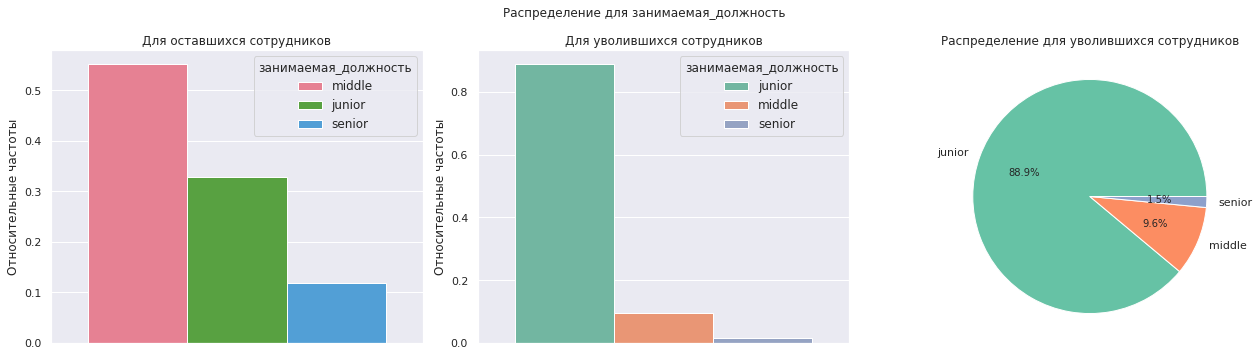

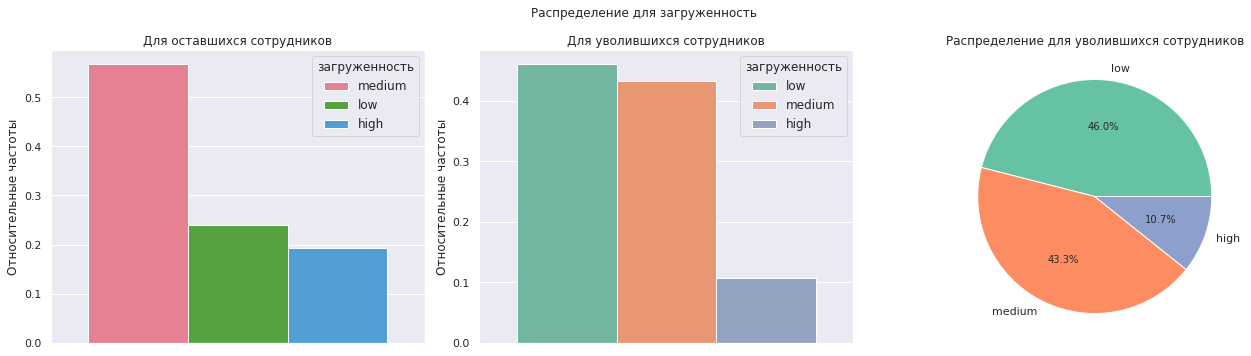

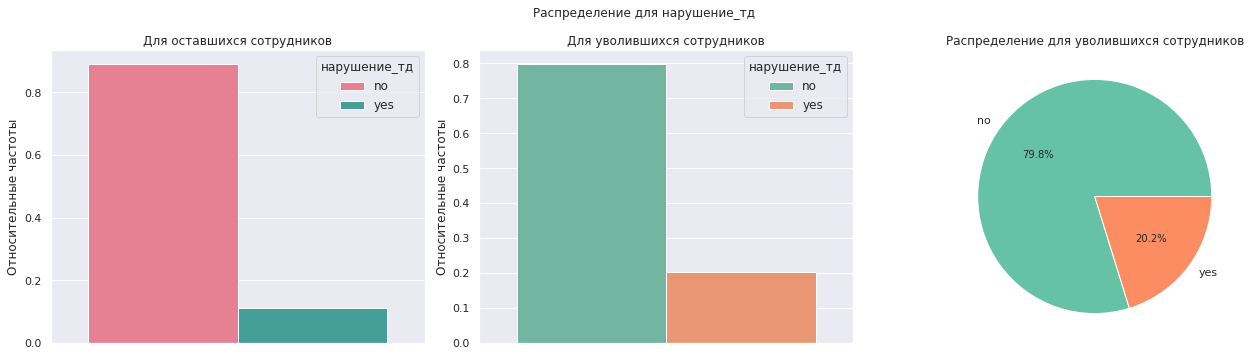

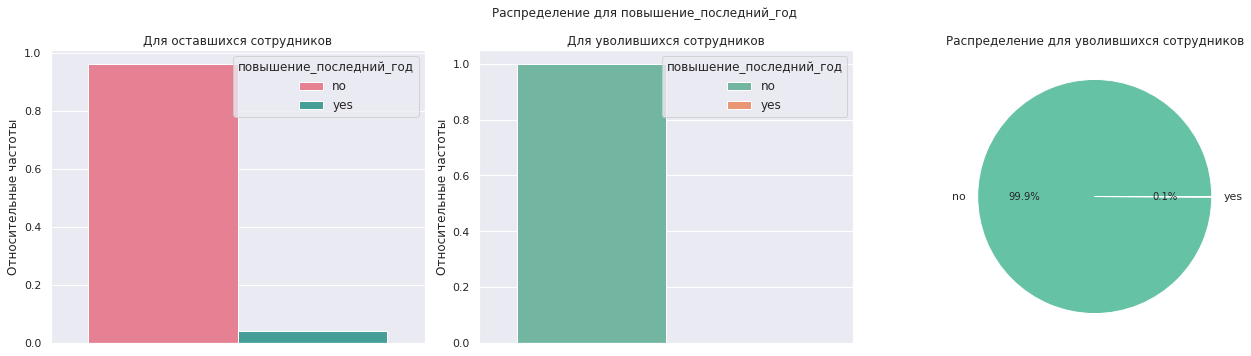

In [91]:
data_categorial = categorial_plot_quit(tr_quit, 'Составление портрета уволившегося сотрудника', categories, 'quit')

На основе построенных графиков можно сделать вывод:
- Чаще увольняются сотрудники начальной должности
- Самые частые отделы для увольнения: `sales` и `technology`
- Большая нагрузка не является причиной увольнения: в процентном соотношении среди уволившихся сотрудников средняя и низкая нагрузка занимают почти равные доли
- Почти половина сотрудников среди нарушивших трудовой договор уволилась, однако 80% уволившихся сотрудников не нарушали договор
- Ни один из сотрудников с повышением не уволились

Графики количественных признаков для Составление портрета уволившегося сотрудника


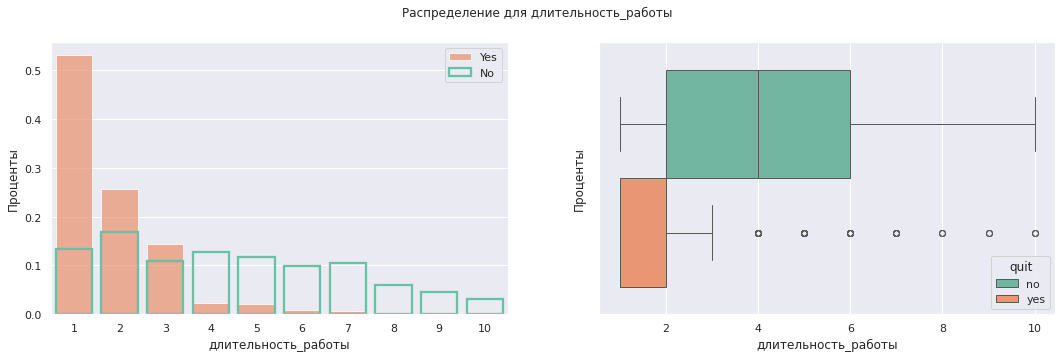

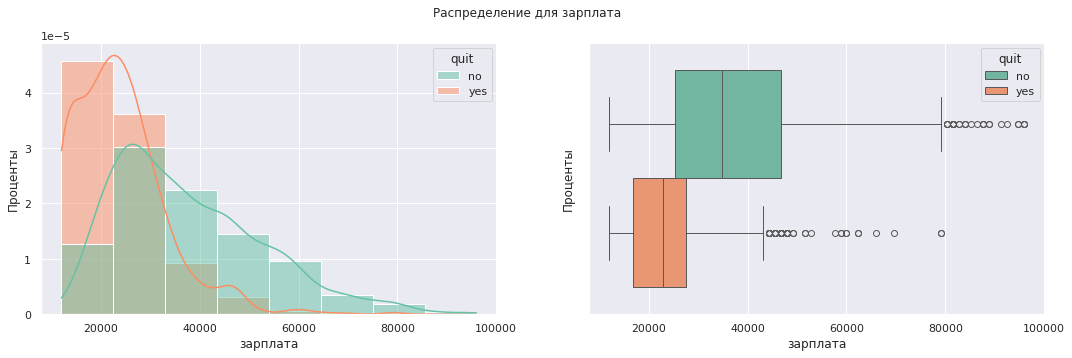

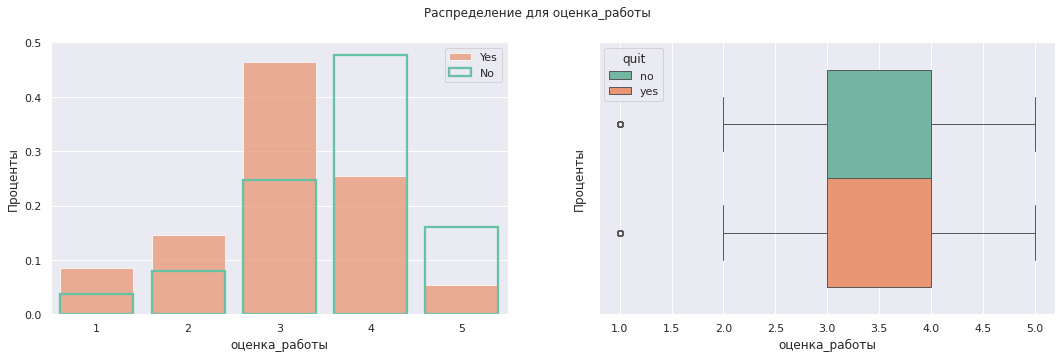

In [92]:
numerical_plot_quit(tr_quit, 'Составление портрета уволившегося сотрудника', numerical_features, 'quit')

На основе построенных графиков можно сделать вывод:
- Чаще всего увольняются сотрудники с зарплатой ниже 40 тыс рублей
- Сотрудники с оценкой работы 3 увольняются чаще других. Следующими по количеству увольнений идут сотрудники с оценкой 4, 2, 1, 5 в порядке убывания

**Предположительный портрет "Уволившегося сотрудника"**:
- Работает на должности уровня `junior` в отделах `sales` или `technology`
- Нагрузка на рабочем месте `low` или `median`
- Не имеют повышения за последний год
- Зарплата ниже 40 тыс. рублей
- Оценка работы равна 3, 4, 2

Рассмотрим теперь, какая существует зависимость `job_satisfaction_rate` от увольнения сотрудника. Для этого построим графики распределения и проведем статистический тест

In [93]:
js_vs_quit = ts_target_quit.merge(ts_target, on='id', how='inner')

Сформулируем гипотезу, которую мы хотим проверить:

$H_0$: Средние двух выборок: уволившиеся сотрудники и неуволившиеся сотрудники равны для параметра `job_satisfaction_rate`

$H_1$: Средние двух выборок не равны

In [94]:
results = ttest_ind(js_vs_quit.query('quit == "yes"')['job_satisfaction_rate'], 
                    js_vs_quit.query('quit == "no"')['job_satisfaction_rate'])

print(f'p-value: {results.pvalue}')

alpha = 0.05

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 1.2311220665173681e-104
Отвергаем нулевую гипотезу


На основе проведенного статистического теста для двух генеральных совокупностей на основе выборок из этох совокупностей мы отвергнули гипотезу о равенстве `job_satisfaction_rate` для уволившихся и неуволившихся сотрудников

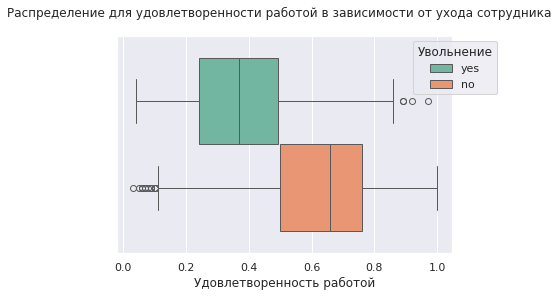

In [95]:
sns.boxplot(data=js_vs_quit, 
            x='job_satisfaction_rate', 
            hue='quit')
plt.suptitle(f'Распределение для удовлетворенности работой в зависимости от ухода сотрудника')
plt.xlabel('Удовлетворенность работой')
plt.legend(title='Увольнение', 
           loc='upper right', 
           bbox_to_anchor=(1.15, 1));

На графике заметно, что удовлетворенность работой для уволившихся сотрудников ниже, чем для оставшихся

**Вывод**:
- На основе проведенного анализа была отвергнута гипотеза о равенстве среднего для параметра `job_satisfaction_rate` в зависимости от увольнения сотрудника
- На основе графического анализа был сделан вывод о том, что увольнение зависит от удовлетворенности сотрудников
- был создан предположительный портрет увольняющегося сотрудника:
    - Работает на должности уровня `junior` в отделах `sales` или `technology`
    - Нагрузка на рабочем месте `low` или `median`
    - Не имеют повышения за последний год
    - Зарплата ниже 40 тыс. рублей
    - Оценка работы равна 3, 4, 2

### Шаг 4. Добавление нового входного признака

Допустим, `job_satisfaction_rate` и `quit` действительно связаны и вы получили необходимое значение метрики в первой задаче. Тогда добавьте `job_satisfaction_rate`, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи.

In [96]:
tr_quit['job_satisfaction_rate'] = best_decision.predict(tr_quit)
ts_features['job_satisfaction_rate'] = best_decision.predict(ts_features)

In [97]:
tr_quit.head()

id        dept   level workload  employment_years last_year_promo  \
0  723290       sales  middle     high                 2              no   
1  814010       sales  junior   medium                 2              no   
2  155091  purchasing  middle   medium                 5              no   
3  257132       sales  junior   medium                 2              no   
4  910140   marketing  junior   medium                 2              no   

  last_year_violations  supervisor_evaluation  salary quit  \
0                   no                      4   54000   no   
1                   no                      4   27600   no   
2                   no                      1   37200   no   
3                  yes                      3   24000  yes   
4                   no                      5   25200   no   

   job_satisfaction_rate  
0               0.660000  
1               0.853529  
2               0.364091  
3               0.380000  
4               0.690000

#### Корреляционный анализ

Рассмотрим корреляцию между входными признаками и тагретом. Для этого построим матрицы корреляции

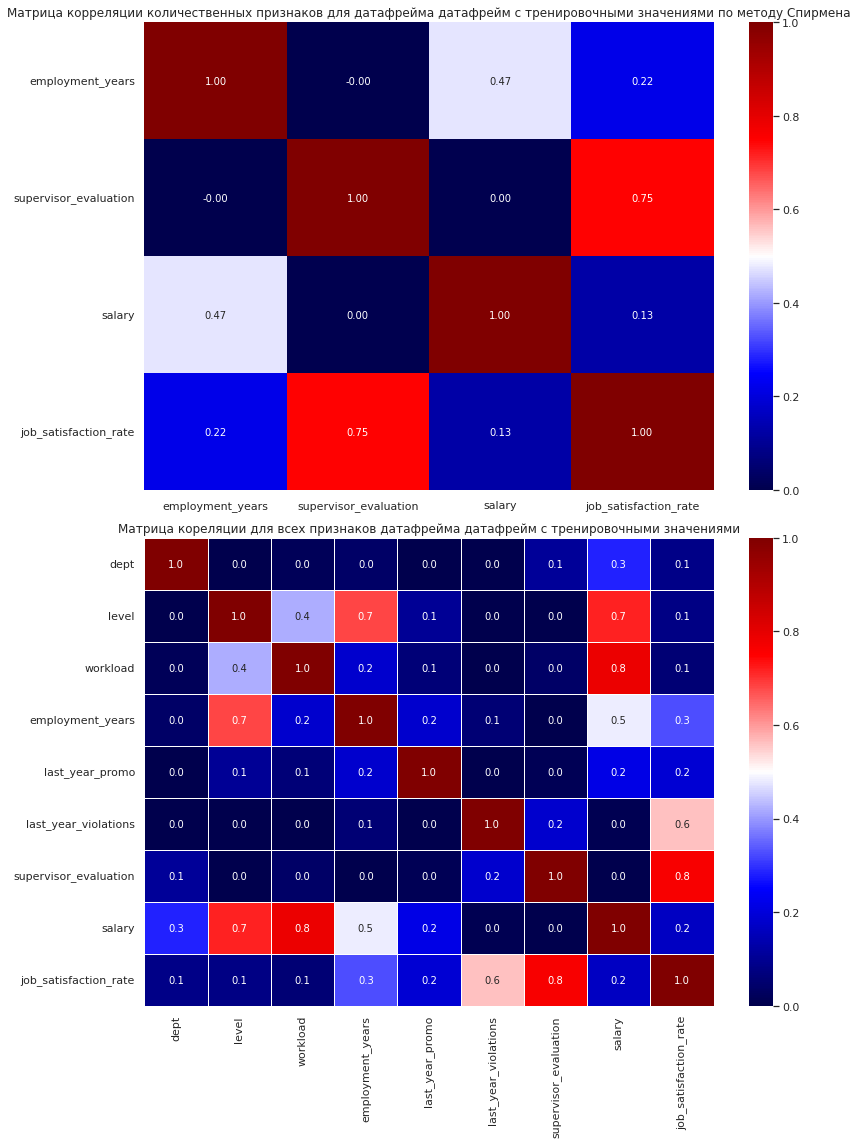

In [98]:
correlation_matrix(tr_satisfaction, numeric_columns_сorr, "датафрейм с тренировочными значениями")

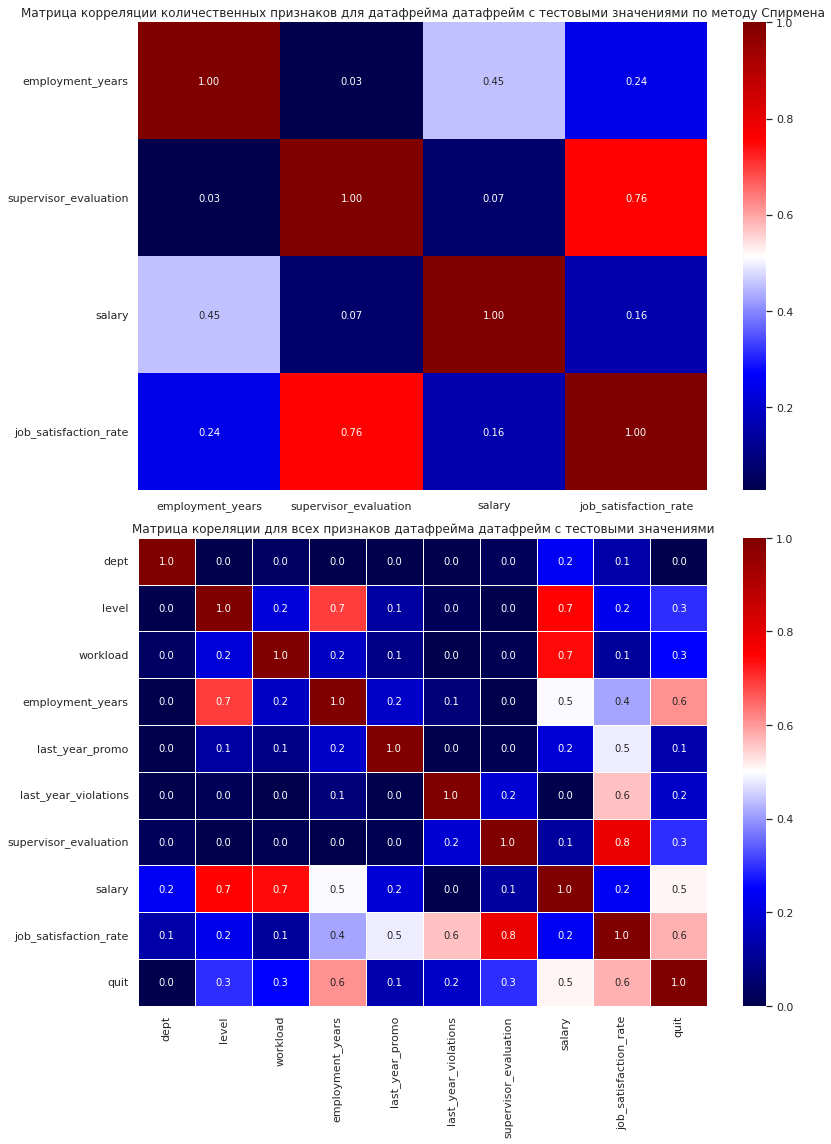

In [99]:
correlation_matrix(ts_features.merge(ts_target_quit, on='id', how='inner'), 
                   numeric_columns_сorr, 
                   "датафрейм с тестовыми значениями")

Поскольку у нас сильная корреляция `last_year_violations` и `supervisor_evaluation` с `job_satisfaction_rate`, то эти признаки использовать для обучения не будем, а также они имеют слабую корреляцию с таргетом

Поскольку нет корреляции между отделом (`dept`) и увольнением сотрудника, то эти данные включать не будем

**Вывод:**

Поскольку в предыдущем этапе мы нашли зависимость между удовлетворенностью работой и увольнением сотрудника, добавим этот признак, предсказанный нашей лучшей моделью в тестовые данные для предсказания ухода сотрудника

### Шаг 5. Подготовка данных

Поскольку мы собираемся дополнить данные лишь одним новым параметром, необходимо добавить столбец `job_satisfaction_rate` для пайплайна, который обрабатывает количественные данные

In [100]:
tr_quit.columns

Index(['id', 'dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary', 'quit', 'job_satisfaction_rate'],
      dtype='object')

In [101]:
ord_col_quit = ['workload', 'level']
ohe_col_quit = ['last_year_promo']
num_cols_quit = ['employment_years', 'salary', 'job_satisfaction_rate', 'supervisor_evaluation']

In [102]:
preprocessor_quit = ColumnTransformer(
    [
        ('ohe', pipe_ohe, ohe_col_quit),
        ('ord', pipe_ord, ord_col_quit),
        ('scaler', pipe_scaler, num_cols_quit)
        ], 
    remainder='passthrough')

In [103]:
pipe_final_quit = Pipeline([
    ('preprocessor', preprocessor_quit),
    ('models', LogisticRegression(penalty='l1', solver='liblinear', random_state=RANDOM_STATE))
])


In [104]:
pipe_final_quit

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('SimpleImputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('SimpleImputer_str',
                                                                   SimpleImputer(fill_value=nan,
                                                                                 missing_values=' ',
                                                                                 strategy='constant')),
                                                                  ('SimpleImputer_again',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('hot_encoder',
                                                                   OneHotEncode...
                                                                  ('SimpleImputer_after',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['workload', 'level']),
                                                 ('scaler',
                                                  Pipeline(steps=[('SimpleImputer_num',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['employment_years', 'salary',
                                                   'job_satisfaction_rate',
                                                   'supervisor_evaluation'])])),
                ('models',
                 LogisticRegression(penalty='l1', random_state=5,
                                    solver='liblinear'))])

### Шаг 6. Обучение модели

Обучим три модели. Метрика оценки качества в этой задаче — ROC-AUC. Критерий успеха: ROC-AUC ≥0.91 на тестовой выборке.

In [105]:
tr_unique_quit = tr_quit.set_index('id').drop_duplicates()

X_train_quit = tr_unique_quit.drop(columns=['quit', 'dept', 'last_year_violations'])
y_train_quit = tr_unique_quit['quit']

In [106]:
test = ts_features.merge(ts_target_quit, on='id', how='inner')

X_test_quit = test.set_index('id').drop(columns=['quit', 'dept', 'last_year_violations'])
y_test_quit = test.set_index('id')['quit']

In [107]:
X_train_quit.head()

level workload  employment_years last_year_promo  \
id                                                          
723290  middle     high                 2              no   
814010  junior   medium                 2              no   
155091  middle   medium                 5              no   
257132  junior   medium                 2              no   
910140  junior   medium                 2              no   

        supervisor_evaluation  salary  job_satisfaction_rate  
id                                                            
723290                      4   54000               0.660000  
814010                      4   27600               0.853529  
155091                      1   37200               0.364091  
257132                      3   24000               0.380000  
910140                      5   25200               0.690000

In [108]:
X_test_quit.head()

level workload  employment_years last_year_promo  \
id                                                          
485046  junior   medium                 2              no   
686555  junior   medium                 1              no   
467458  middle      low                 5              no   
418655  middle      low                 6              no   
789145  middle   medium                 5              no   

        supervisor_evaluation  salary  job_satisfaction_rate  
id                                                            
485046                      5   28800               0.863333  
686555                      4   30000               0.670417  
467458                      4   19200               0.654000  
418655                      4   19200               0.655000  
789145                      5   40800               0.824643

In [109]:
y_test_quit

id
485046     no
686555     no
467458     no
418655     no
789145     no
         ... 
393147    yes
109582    yes
305653    yes
160233     no
771859     no
Name: quit, Length: 2000, dtype: object

In [110]:
params_grid_quit = [
    {
        'models': [LogisticRegression(penalty='l1', random_state=RANDOM_STATE, solver='liblinear')],
        'models__C': range(2, 4),
        'preprocessor__scaler': [MinMaxScaler(), RobustScaler(), StandardScaler(), 'passthrough']
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__kernel': ['linear', 'rbf'],
        'models__class_weight': ['balanced'],
        'preprocessor__scaler': [MinMaxScaler(), RobustScaler(), StandardScaler(), 'passthrough']
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 10),
        'models__weights': ['uniform', 'distance'],
        'preprocessor__scaler': [MinMaxScaler(), RobustScaler(), StandardScaler(), 'passthrough']
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__min_samples_split': range(2, 5),
        'preprocessor__scaler': [MinMaxScaler(), RobustScaler(), StandardScaler(), 'passthrough']
    },
]

label_encoder = LabelEncoder()

In [111]:
y_train_encoder = label_encoder.fit_transform(y_train_quit)
y_test_encoder = label_encoder.transform(y_test_quit)

In [112]:
y_test_encoder

array([0, 0, 0, ..., 1, 0, 0])

In [113]:
encoder_series = pd.Series(y_train_encoder, index=y_train_quit.index, name='encoder')

pd.concat([pd.Series(y_train_encoder, index=y_train_quit.index, name='encoder'),
           pd.Series(y_train_quit, index=y_train_quit.index, name='original')], axis=1).head()

encoder original
id                      
723290        0       no
814010        0       no
155091        0       no
257132        1      yes
910140        0       no

In [114]:
gs_search_quit = RandomizedSearchCV(
    pipe_final_quit, 
    params_grid_quit, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    n_iter=50
)
gs_search_quit.fit(X_train_quit, y_train_encoder)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('SimpleImputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('SimpleImputer_str',
                                                                                                SimpleImputer(fill_value=nan,
                                                                                                              missing_values=' ',
                                                                                                              strategy='constant')),
                                                                                               ('SimpleImputer_again',
                                                                                                SimpleImputer(strategy='most_frequ...
                                         'models__weights': ['uniform',
                                                             'distance'],
                                         'preprocessor__scaler': [MinMaxScaler(),
                                                                  RobustScaler(),
                                                                  StandardScaler(),
                                                                  'passthrough']},
                                        {'models': [DecisionTreeClassifier(random_state=5)],
                                         'models__max_depth': range(2, 5),
                                         'models__min_samples_split': range(2, 5),
                                         'preprocessor__scaler': [MinMaxScaler(),
                                                                  RobustScaler(),
                                                                  StandardScaler(),
                                                                  'passthrough']}],
                   random_state=5, scoring='roc_auc')

In [115]:
best_decision_quit = gs_search_quit.best_estimator_
best_model_quit = best_decision_quit.named_steps['models']
best_params = gs_search_quit.best_params_

In [116]:
pd.DataFrame(gs_search_quit.cv_results_).sort_values(by='rank_test_score', ascending=True).head(5)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
34       0.375238      0.009431         0.025753        0.001604   
37       0.387443      0.012603         0.027076        0.002506   
44       0.018588      0.000447         0.014422        0.000260   
12       0.018368      0.001813         0.012975        0.002058   
49       0.019043      0.001089         0.013791        0.001807   

   param_preprocessor__scaler param_models__weights param_models__n_neighbors  \
34             MinMaxScaler()                   NaN                       NaN   
37             RobustScaler()                   NaN                       NaN   
44             MinMaxScaler()               uniform                         9   
12           StandardScaler()               uniform                         9   
49           StandardScaler()               uniform                         8   

                                         param_models  \
34  SVC(class_weight='balanced', probability=True,...   
37  SVC(class_weight='balanced', probability=True,...   
44                             KNeighborsClassifier()   
12                             KNeighborsClassifier()   
49                             KNeighborsClassifier()   

   param_models__min_samples_split param_models__max_depth  ...  \
34                             NaN                     NaN  ...   
37                             NaN                     NaN  ...   
44                             NaN                     NaN  ...   
12                             NaN                     NaN  ...   
49                             NaN                     NaN  ...   

   param_models__C                                             params  \
34             NaN  {'preprocessor__scaler': MinMaxScaler(), 'mode...   
37             NaN  {'preprocessor__scaler': RobustScaler(), 'mode...   
44             NaN  {'preprocessor__scaler': MinMaxScaler(), 'mode...   
12             NaN  {'preprocessor__scaler': StandardScaler(), 'mo...   
49             NaN  {'preprocessor__scaler': StandardScaler(), 'mo...   

   split0_test_score split1_test_score  split2_test_score  split3_test_score  \
34          0.925982          0.905793           0.904026           0.894534   
37          0.921544          0.897213           0.904224           0.896353   
44          0.925015          0.894866           0.905124           0.885457   
12          0.927777          0.893051           0.905945           0.889511   
49          0.926751          0.893574           0.903611           0.888492   

    split4_test_score  mean_test_score  std_test_score  rank_test_score  
34           0.921143         0.910296        0.011591                1  
37           0.920530         0.907973        0.011015                2  
44           0.927738         0.907640        0.016538                3  
12           0.919818         0.907220        0.014814                4  
49           0.916446         0.905775        0.014185                5  

[5 rows x 22 columns]

In [117]:
print('Лучшая модель и её параметры:\n\n', best_decision_quit)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('SimpleImputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('SimpleImputer_str',
                                                                   SimpleImputer(fill_value=nan,
                                                                                 missing_values=' ',
                                                                                 strategy='constant')),
                                                                  ('SimpleImputer_again',
                                                                   SimpleImputer(strategy='most_frequent')),
                                    

In [118]:
print(f'Метрика ROC-AUC лучшей модели по кросс-валидации на обучающих данных: {round(gs_search_quit.best_score_,4)}')

Метрика ROC-AUC лучшей модели по кросс-валидации на обучающих данных: 0.9103


In [119]:
X_Test_quit = best_decision_quit['preprocessor'].transform(X_test_quit)

In [120]:
pred_proba = gs_search_quit.predict_proba(X_test_quit)[:,1]
print(f'Метрика roc_auc на тестовой выборке: {round(roc_auc_score(y_test_encoder, pred_proba), 4)}')

Метрика roc_auc на тестовой выборке: 0.9212


In [121]:
if type(best_model_quit) == DecisionTreeClassifier:
    print(best_model_quit.feature_importances_)

### Интерпретация результатов модели

Оценим важность признаков лучшей модели, для этого построим графики с помощью библиотеки `shap`

In [122]:
feature_names_ohe_quit = list(best_decision_quit['preprocessor'].transformers_[0][1][3].get_feature_names_out())

feature_names_ohe_quit

['x0_yes']

In [123]:
feature_names_ohe_quit_with_values = list(map(lambda x: f"{x}_{ohe_col_quit[0]}", feature_names_ohe_quit))
feature_names_ohe_quit_with_values

['x0_yes_last_year_promo']

In [124]:
feature_names_quit = feature_names_ohe_quit_with_values + ord_col_quit + num_cols_quit

In [125]:
best_decision_quit.fit(X_train_quit, y_train_encoder)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('SimpleImputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('SimpleImputer_str',
                                                                   SimpleImputer(fill_value=nan,
                                                                                 missing_values=' ',
                                                                                 strategy='constant')),
                                                                  ('SimpleImputer_again',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('hot_encoder',
                                                                   OneHotEncode...
                                                                                              ['junior',
                                                                                               'middle',
                                                                                               'senior']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('SimpleImputer_after',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['workload', 'level']),
                                                 ('scaler', MinMaxScaler(),
                                                  ['employment_years', 'salary',
                                                   'job_satisfaction_rate',
                                                   'supervisor_evaluation'])])),
                ('models',
                 SVC(class_weight='balanced', probability=True,
                     random_state=5))])

In [126]:
x_Train_quit = pd.DataFrame(best_decision_quit['preprocessor'].fit_transform(X_train_quit),
                      columns=feature_names_quit)
x_Test_quit = pd.DataFrame(best_decision_quit['preprocessor'].transform(X_train_quit),
                     columns=feature_names_quit)

In [127]:
explainer_quit = shap.KernelExplainer(best_model_quit.predict_proba, x_Train_quit[:100])

shap_values_quit = explainer_quit.shap_values(x_Test_quit[:100])[:, :, 0]

title = "Силовой график SHAP: Влияние особенностей на прогнозирование модели, предсказывающей увольнение"
title_length = len(title)
print(f"{title:^{title_length + 40}}")
shap.force_plot(explainer_quit.expected_value[0], shap_values_quit, x_Test_quit)


  0%|          | 0/100 [00:00<?, ?it/s]

                    Силовой график SHAP: Влияние особенностей на прогнозирование модели, предсказывающей увольнение                    


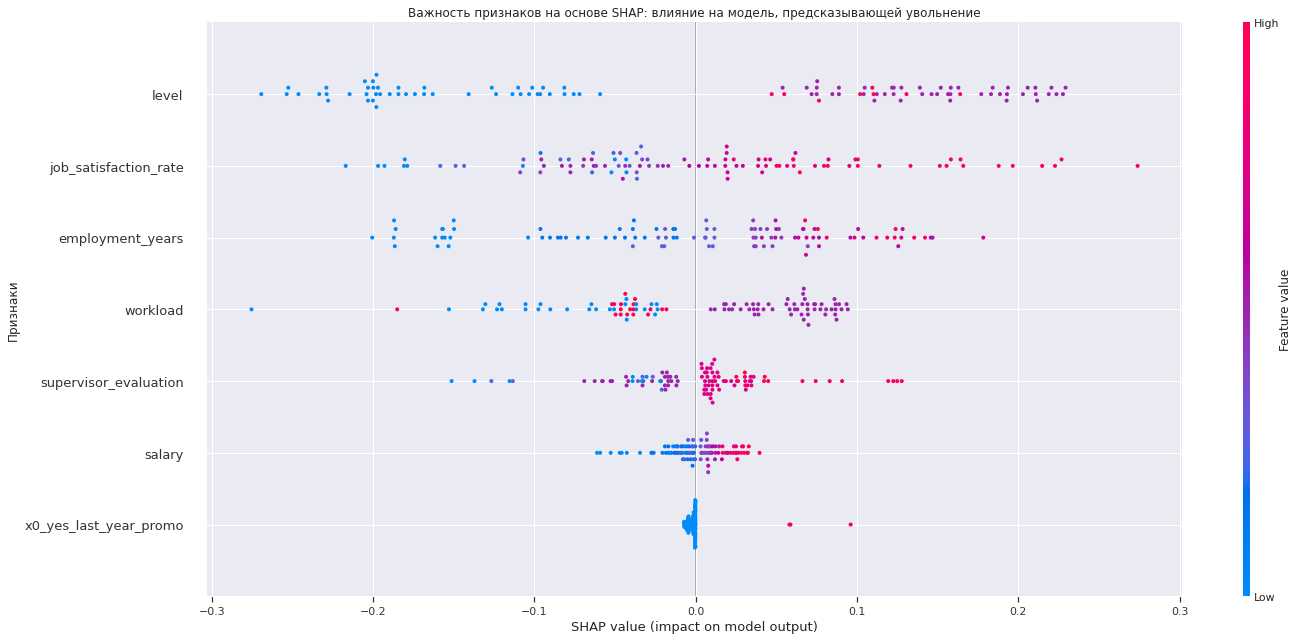

In [128]:
plt.title('Важность признаков на основе SHAP: влияние на модель, предсказывающей увольнение')
plt.ylabel('Признаки');
shap.summary_plot(shap_values_quit, x_Test_quit[:100], plot_size=(20,9))

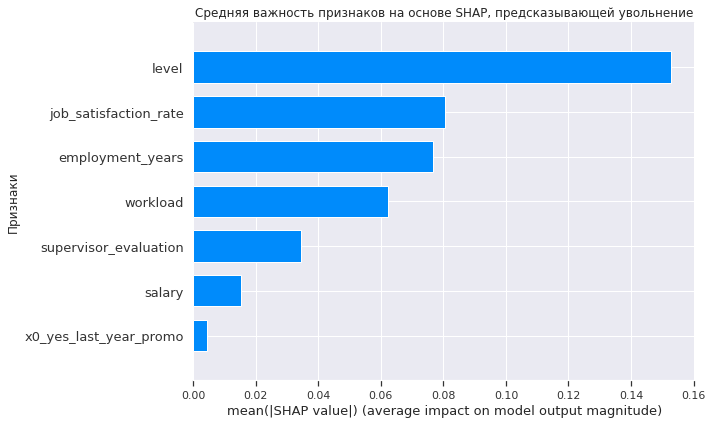

In [129]:
plt.title('Средняя важность признаков на основе SHAP, предсказывающей увольнение')
plt.ylabel('Признаки');
shap.summary_plot(shap_values_quit, x_Test_quit[:100], plot_type="bar", plot_size=(10,6))

**Вывод**:

Как и в "предполагаемом портрете" уволившегося сотрудника уровень должности, уровень удовлетворенности работой, количество отработанных лет являются признаками, которые показывают, будет ли сотрудник увольняться, признаки расположены в порядке убывания значимости

Также на решение модели оказали влияние такие параметры, как загруженность на работе, зарплата, оценка качества работы сотрудника, повышение за последний год

При разработке "портрета" на эти признаки также было обращено внимание

### Шаг 7. Выводы

В результате разработки решения для предсказания увольнения сотрудника лучше всего справилась модель SVC, которая показала на тестовой выборке результат 0.92, что является удовлетворительным результатом работы

При разработке было обращено внимание на признаки, которые передаются модели для обучения и в связи с отсутствием корреляции и мультиколлинеарности количество исходных параметров было сокращено: не использовались параметры `last_year_violations` и `supervisor_evaluation` в связи с мультиколлинеарностью и `debt`, поскольку не было корреляции с таргетом

На этапе предобработки были использованы кодировщики для категориальных признаков, а именно `OneHotEncoder`, `OrdinalEncoder`
Для количественных данных был выполнен подбор скейлеров среди `MinMaxScaler`, `RobustScaler`, `StandardScaler`, лучший результат показал `MinMaxScaler`

## Общий вывод

Стояла задача, которую необходимо решить в два этапа:

- На основе данных о сотруднике предсказать его уровень удовлетворенности работой
- На основе предоставленных данных и предсказанном уровне удовлетворенности работой сделать предположение о уходе сотрудника.

Данное решение поможет избежать оттока сотрудников, для снижения рисков работы компании

<u>**Для предсказания удовлетворенностью были предприняты следующие шаги:**</u>
- Проанализированны данные, полученные от аналитиков компании, рассмотрены статистические и графические интерпретации количественных и категориальных данных. Сделаны выводы:
    - Для количественных признаков:
        - Среди распределений количественных данных нет нормального распределения.
        - Для длительности работы мода - 1 год работы и далее количество сотрудников уменьшается с количеством года
        - Наиболее часто ставят оценку 4, потом 3 и далее 5, 2 и 1 по убыванию. Однако количество проставления единиц мало по сравнению с другими оценками - в тренировочных данных 200 единиц на 4000 данных.
        - Зарплаты выше 80 тыс рублей считаются статистическими выбросами, однако это вполне могут быть зарплатами руководителей
    - Для категориальных признаков:
        - На основе построенных графиков и статистических значений, самый популярный отдел - sales, в тренировочной выборке в нем работает 1512 сотрудников
        - Большую часть сотрудников составляют джуны и мидлы - их 47,4% и 43,6% соответственно
        - Для большинства сотрудников загруженность на работе на среднем уровне - это 51,6%, далее сотрудники оценили нагрузку как низкую - 30% и высокой она оказалась для 18,4% - примерно 750 человек
        - За последний год повышение получили только 3% сотрудников
        - 14% или 559 человек из тренировочной нарушили трудовой договор за последний год
    - был проведен корреляционный анализ, в ходе которого мультиколлинеарности в данных не было обнаружено
    - При обезличивании данных обнаружены дубликаты - для тренировочной 245 и 554 для тестовой. Было рассмотрено к каким отделам и уровню занимаемой должности эти дубликаты относятся и было принято решение для тестовой их оставить.
- Для работы модели был создан пайплайн, включающий в себя предобработку данных:
    - Заполнение пропусков
    - Обработку категориальных признаков при помощи `OrdinalEncoder` и `OneHotEncoder`
    - Стандартизирование и подбор лучшего подхода из `MinMaxScaler` и `StandartScaler`
- Для поиска лучшей модели был использован метод GridSearchCV или "переборпо сетке", где были рассмотрены модели:
    - Lasso, DecisionTreeRegressor, Ridge
- Для интерпретации работы лучшей модели была использована библиотека `shap`

Вывод для задачи предсказания уровня удовлетворенности сотрудников:
- Основное влияние на решение модели относительно уровня удовлетворенности является оценка сотрудника - чем она будет выше, тем больше будет уровень удовлетворенности
- Чем дольше сотрудник работает в компании, тем больше его уровень удовлетворенности компанией, что вполне закономерно
- При нарушении сотрудником трудового договора, его удовлетворенность работой снимажется - этот признак вносит вклад в снижение уровня удовлетворенности
- Так же значительный вклад вносит уровень и уровень загруженности - он вносит вклад в снижение уровня удовлетворенности работы
- Повышение за последний год положительно влияет на уровень удовлетворенности

<u>**Для предсказания ухода сотрудников были сделаны следующие шаги:**</u>
- Проведен исследовательский анализ для новых тестовых данных, в них сохраняются закономерности из первой задачи
- Был проведен анализ признаков в зависимости от ухода сотрудников:
    - Была выявлена зависимость между `job_satisfaction_rate` и уходом сотрудников
    - Был составлен преждполагаемый "портрет уволившегося сотрудника":
        - Работает на должности уровня `junior` в отделах `sales` или `technology`
        - Нагрузка на рабочем месте `low` или `median`
        - Не имеют повышения за последний год
        - Зарплата ниже 40 тыс. рублей
        - Оценка работы равна 3, 4, 2
     - Был проведен корреляционный анализ признаков от таргета. В результате:
         - `last_year_violations` и `supervisor_evaluation` в связи с мультиколлинеарностью были убраны из параметров обучения модели
         - Также убран параметр `debt`, поскольку не было корреляции с таргетом
- Для разработки модели был использовался пайплайн, в котором реализованы 
    - кодировки категориальных признаков с помощью `OrdinalEncoder` и `OneHotEncoder`, а также кодировка таргета при помощи `LabelEncoder`
    - стандартизация количественных признаков с помощью `MinMaxScaler`, `RobustScaler`, `StandardScaler`
- На этапе разработки решения использовались модели `LogisticRegression`, `SVC`, `KNeighborsClassifier`, `DecisionTreeClassifier`, перебираемые с помощью RandomizedSearchCV
- Лучший результат показала модель `SVC` совместно с `MinMaxScaler`, который равен 0.92 на тестовой выборке, что удовлетворяет условиям разработки

<u>**Рекомендации для бизнеса**</u>
- Поскольку уволнялись сотрудники с низкой загруженностью, а также уровня `junior` это может свидетельствовать о несоответствии обещаний и ожиданий к работе. Для снижения увольнения `junior` специалистов, отделу hr стоит уделять больше внимания на должностные обязанности будующего сотрудника и его ожидания
- Возможно стоит сделать более прозрачной оценку работы сотрудника, чтобы это его не демотивировало, а служило стимулом для развития. Возможно при каких-то технических пробелах стоит привлекать сотрудников к дополнительному обучению и конференциям, чтобы сотрудник чувствовал заинтересованность компании в его развитии